## Backup Reminder : DO IT!

In [1]:
# All the necessary imports
import actr
import pickle
import random
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from itertools import groupby

ACT-R connection has been started.


In [2]:
help(actr)

Help on module actr:

NAME
    actr

CLASSES
    builtins.object
        actr
        interface
        request
    
    class actr(builtins.object)
     |  actr(host, port)
     |  
     |  Methods defined here:
     |  
     |  __init__(self, host, port)
     |      Initialize self.  See help(type(self)) for accurate signature.
     |  
     |  add_command(self, name, function, documentation='No documentation provided.', single=True, actr_name=None)
     |  
     |  evaluate(self, *params)
     |  
     |  evaluate_single(self, *params)
     |  
     |  monitor_command(self, original, monitor)
     |  
     |  remove_command(self, name)
     |  
     |  remove_command_monitor(self, original, monitor)
     |  
     |  ----------------------------------------------------------------------
     |  Data descriptors defined here:
     |  
     |  __dict__
     |      dictionary for instance variables (if defined)
     |  
     |  __weakref__
     |      list of weak references to the obje

## Experiment Logs
    - 10th June 2020: 06:50am
        - Testing the plotting function.
        - Backing up the code to github: Done
        

## Control Flow Logs
    - Flow of the program in simple words
        -Need to understand the ACT-R Model first 
    - Data Structures, their shapes and the purpose of their existence

#### Word lists do not contain actual words?
    No they don't, we will do this in later experiment
#### Number of words in each list i.e. list_length should be n where (n-2)%3 == 0 because 2 neutral words are added in each list.

#### The adjustable parameters in this experiment code.
    - Number of lists
    - Number of words in each list
    - The time taken for rehearsal (6 + delay of .5 seconds) and recall(10)
#### Adjustable parameters in ACT-R
    - :declarative-num-finsts 21 ; number of items that are kept as recently retrieved (Change it to 5) 
    - :declarative-finst-span 21 ; how long items stay in the recently-retrieved state (5,100)

In [3]:
### Experiment part ###

subject = ''

current_list = ''

recalled_words = defaultdict(list)

rehearsed_words =  defaultdict(lambda: defaultdict(int))

list_amount = 1    # No of lists

list_length = 83    # No of words in a list

rehearsal_time = 6  # No of seconds for which rehearsal happens and each word is shown

delay = 0.1  #delay between rehearsal and recall

recall_time = 10 

In [4]:
word_lists_dict = defaultdict(list)

# Ensure there are enough unique words to create the word lists
word_dict = {"positive": ["positive" + str(i) for i in range(999)],
             "negative": ["negative" + str(i) for i in range(999)],
             "neutral": ["neutral" + str(i) for i in range(999)]}

In [5]:
def add_words(i, list_length):
    '''
    Add the words to the word lists, ensures valence categories are balanced
    '''
    global word_lists_dict

    amnt_wanted = (list_length -2)/3   # Amount of each valence wanted, minus 2 neutrals controlling for primacy
    amt_positive, amt_negative, amt_neutral, count = 0, 0, 0, 0
    while len(word_lists_dict[i]) != list_length:
        count += 1
        #print(f"...................{count,word_lists_dict[i]}")
        if count >= 9999: # IF it takes too long to create a unique list at random, start over
            word_lists_dict[i] = []
            add_words(i, list_length)
        if len(word_lists_dict[i]) == 0: # Place two neutral words at the start to control for primacy effects
            word_to_add1 = word_dict["neutral"][random.randint(0, len(word_dict["neutral"])-1)]
            word_to_add2 = word_dict["neutral"][random.randint(0, len(word_dict["neutral"])-1)]
            if word_to_add1 not in word_lists_dict[i] and word_to_add2 not in word_lists_dict[i] and word_to_add1 != word_to_add2:
                word_lists_dict[i].append(word_to_add1)
                word_lists_dict[i].append(word_to_add2)
            else:
                continue # skip this loop iteration                   
        else: 
            random_valence = random.choice(["positive", "negative", "neutral"])
            word_to_add = word_dict[random_valence][random.randint(0, len(word_dict[random_valence])-1)]
            if word_to_add not in word_lists_dict[i] and word_lists_dict[i][-1] not in word_dict[random_valence] and \
               amt_positive <= amnt_wanted and amt_negative <= amnt_wanted and amt_neutral <= amnt_wanted:
                if random_valence == "positive" and amt_positive < amnt_wanted:
                    amt_positive += 1
                elif random_valence == "negative" and amt_negative < amnt_wanted:
                    amt_negative +=1
                elif random_valence == "neutral" and amt_neutral < amnt_wanted:
                    amt_neutral +=1
                else:
                    continue # skip this loop iteration
                word_lists_dict[i].append(word_to_add)

In [6]:
def create_lists(list_amount=3, list_length=2):
    '''
    Create the wordlists used during the free recall tasks 
    '''  
    global word_lists_dict 

    for i in range(list_amount):
        print(f'List {i+1}/{list_amount} created!', end="\r")
        add_words(i, list_length)

    # Save the dictionary to a .pickle file, so we do not have to create the word lists everytime we run the model                    
    file = open(f"word_lists\word_lists_dict_{list_length}_{list_amount}.pickle","wb")
    pickle.dump(word_lists_dict, file)
    file.close()
    return word_lists_dict

In [7]:
# Check if the word lists already exist, else create new word lists
try:
    file = open(f"word_lists\word_lists_dict_{list_length}_{list_amount}.pickle","rb")
    #file = open(f"word_lists_dict_100_items_only.pickle","rb")
    word_lists_dict = pickle.load(file)  
    file.close()
    print("\nSuccesfully loaded the word lists!\n")
except FileNotFoundError:
    print("\nCreating word lists!\n")
    #amount_to_create = list_amount                              
    word_lists_dict = create_lists(list_amount,list_length)


Succesfully loaded the word lists!



In [8]:
def display_word_lists():
    '''
    Display the word lists loaded/created
    '''
    for key, value in word_lists_dict.items():
        print(f'List {key}:\n {value}\n')

def close_exp_window():
    '''
    Close opened ACT-R window
    '''
    return actr.current_connection.evaluate_single("close-exp-window")

In [9]:
def prepare_for_recall(): 
    '''
    Disable rehearsing productions, and clearing buffer contents to start the recalling phase 
    '''
    disable_list = ["rehearse-first", "rehearse-second", "rehearse-third", "rehearse-fourth", 
                    "rehearse-it", "skip-first", "skip-second", "skip-third", "skip-fourth"]
    for prod in disable_list:
        actr.pdisable(prod)
    actr.run(1, False) 
    for buff in ["imaginal", "retrieval", "production"]:
        actr.clear_buffer(buff)  

In [10]:
def setup_dm(word_list):
    '''
    Add words to declarative memory, since it can be assumed the test subjects know the English language already
    '''
    #print("\n\n############################################# Inside setup_dm i.e. Declarative Memory")
     
    colour_conversion = {'pos': 'GREEN', 'neg': 'RED', 'neu': 'BLACK'}
    for idx, word in enumerate(word_list):
        valence = ''.join([char for char in word if not char.isdigit()])[:3]
        actr.add_dm(('item'+str(idx), 'isa', 'memory', 'word', "'"+word+"'"))#, 'valence', colour_conversion[valence]))
#         if idx == 0:
#             print("\n Emaple of a chunk added in Declarative Memory is \n")
#             print('item'+str(idx), 'isa', 'memory', 'word', "'"+word+"'", 'valence', colour_conversion[valence],"\n")
        

In [11]:
def setup_experiment(human=True):
    '''
    Load the correct ACT-R model, and create a window to display the words
    '''
#     print("\n\n############################################# Inside setup_experiment")
#     print(f'\nSubject = {subject}\n')  

    loaded = None
    if subject == "controls":
        loaded = actr.load_act_r_model(r"C:\Users\cleme\Documents\Education\RUG\First-Year_Research\My_Project\Model\models\free_recall_regular_v1.lisp")
        #loaded = actr.load_act_r_model(r"C:\Users\cleme\Documents\Education\RUG\First-Year_Research\My_Project\Model\models\csm_free_recall_model_test.lisp")
    elif subject == "depressed":
        loaded = actr.load_act_r_model(r"C:\Users\cleme\Documents\Education\RUG\First-Year_Research\My_Project\Model\models\csm_free_recall_model_depressed.lisp")
    
    #print("\n\n############################################# Inside setup_experiment")
    #print(f'\nLoaded Act-r model = {loaded}\n')  



    window = actr.open_exp_window("Free Recall Experiment", width=1024, height=768, visible=human) # 15inch resolution window
    actr.install_device(window) 
    return window    

In [12]:
def record_words_recalled(item):
    '''
    Register which words were recalled during the experiment for a specific wordlist and strip the numbers
    '''
    valence = ''.join(char for char in item if not char.isdigit())
    item_idx = ''.join(char for char in item if char.isdigit())
    recalled_words[current_list].append((valence, item_idx))
   

In [13]:
def create_result_dict():
    '''
    Use a module-level function, instead of lambda function, to enable pickling it
    '''
    return defaultdict(int)

In [14]:
def record_words_rehearsed(item):
    '''
    Register amount of rehearsals per word for each wordlist
    '''
    rehearsed_words[current_list][item] += 1

# Testing Creation of Plots which involves testing
    - create_lplot(idx, xlabel, ylabel, x, y, xticks_len, filename, ytick_range=None, show=False)
    - analysis(wlist_amount, show_plots=False)

In [15]:

def create_lplot(idx, xlabel, ylabel, x, y, xticks_len, filename, ytick_range=None, show=False):
    '''
    Create line plot using matplotlib
    Args:
        Input:
            -idx: The id of the type of plot to be made.
                  0: Rehearse Freuency
                  1: Starting Recall
                  2: Recall Probability
            -xlabel: Label for x-axis of the plot (Serial Input Position for this experiment).
            -ylabel: Label for y-axis of the plot (One of idx 0,1 or 2).
            -x: Serial Input Positions which depends on the length of the words list ex: range(1,20).
                shape: (1, list_length)
            -y: Values for the idx 0,1 or 2.
                shape: (list_length,)
            -xticks_len: length for ticks on x-axis, same as len(x)
            -filename: name for saving the file
            -ytick_range: length for ticks on y-axis, 0-1 for probabilities, None for rehearse frequency
            -show: To show the plot here or not.
        Output:
            Saved plots of rehearse frequency, starting recall and recall probability.
    '''
    plt.figure(idx)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.plot(x, y)
    plt.xticks(np.arange(0, xticks_len, 1)) 
    plt.yticks(ytick_range)
    plt.savefig("images/"+subject+"_"+filename, bbox_inches='tight')
    if show:
        plt.show()
 

In [16]:
def analysis(wlist_amount, show_plots=False):
    '''
    Review results of the recall experiment
    Args:
        Input:
            -wlist_amount: No of words inside each list
            -show_plots: Boolean to control the display of plots after experiment
        Output:
            -Saved plots for rehearse frequency, starting recall and recall probability after complete analysis.
    
    '''
    result_dict = defaultdict(create_result_dict) # instead of defaultdict(lambda: defaultdict(int))
    first_recall = defaultdict(int)
    recall_probability = defaultdict(int)
    rehearse_frequency = defaultdict(int)
    transitions_amnt = 0
    thought_train_len = []

    for key, val in recalled_words.items():
        thought_train_len.extend([(k, sum(1 for _ in count)) for k, count in groupby([val[0] for val in val[2:]])])
        for idx, (retrieved_word, item_num) in enumerate(val[2:]):
            if idx != 0:
                if retrieved_word != val[2:][idx-1][0]:
                    transitions_amnt += 1/wlist_amount # average over word lists

    print(f'Avg. Amount of recall transitions = {int(transitions_amnt)}')
    neg_thought_train_len = 0
    neg_divider = 0.0001
    for x in thought_train_len:
        if x[0] == 'negative':
            neg_divider += 1
            neg_thought_train_len += x[1]
    print(f'Avg. Negative Thought train length = {round(neg_thought_train_len/neg_divider, 3)}')            

    for list_num, wlist in word_lists_dict.items():
        if list_num < wlist_amount:
            for key, val in recalled_words.items():
                if key==list_num:
                    first_recall[wlist.index(''.join(val[0]))] += 1   
                    for idx, word in enumerate(wlist):
                        first_recall[idx] += 0
                        if ((''.join(char for char in word if not char.isdigit()), 
                             ''.join(char for char in word if char.isdigit()))) in val:
                            recall_probability[idx] += 1
                        else:
                            recall_probability[idx] += 0                            
                for retrieved_word, item_num in val[2:4]:
                    result_dict["pstart"][retrieved_word] += 1  
                for retrieved_word, item_num in val[4:-2]:
                    result_dict["pstay"][retrieved_word] += 1
                for retrieved_word, item_num in val[-2:]:
                    result_dict["pstop"][retrieved_word] += 1                                                        
            for key, val in rehearsed_words.items():
                if key==list_num:
                    for idx, word in enumerate(wlist):
                        rehearse_frequency[idx] += rehearsed_words[key][word]
    
    for key, val in first_recall.items():
        first_recall[key] = val/wlist_amount

    for key, val in recall_probability.items():
        recall_probability[key] = val/wlist_amount

    for key, val in rehearse_frequency.items():
        rehearse_frequency[key] = val/wlist_amount      

    xticks_len = len(word_lists_dict[0])
  
    create_lplot(0, 'Serial input position', 'Rehearse Frequency', range(len(word_lists_dict[0])), list(rehearse_frequency.values()), 
                xticks_len, f'v1_rehearse_frequency_{list_length}_{list_amount}_{rehearsal_time}_{recall_time}.png', None, show_plots)

    create_lplot(1, 'Serial input position', 'Starting Recall', range(len(word_lists_dict[0])), list(first_recall.values()), 
                xticks_len, f'v1_starting_recall_{list_length}_{list_amount}_{rehearsal_time}_{recall_time}.png', np.arange(0, .5, .1), show_plots)                

    create_lplot(2, 'Serial input position', 'Recall Probability', range(len(word_lists_dict[0])), list(recall_probability.values()), 
                xticks_len, f'v1_recall_probability_{list_length}_{list_amount}_{rehearsal_time}_{recall_time}.png', np.arange(0, 1, .1), show_plots)   
    
#     create_lplot(3, 'Serial input position', 'Accuracy', range(len(word_lists_dict[0])), list(recall_accuracy.values()), 
#                 xticks_len, 'recall_accuracy.png', np.arange(0, 1, .1), show_plots) 

    file = open("results_"+subject+".pickle","wb")
    pickle.dump(result_dict, file)
    file.close()

    return result_dict

In [17]:
def do_experiment(subj="depressed", human=False, wlist_amount=2000):
    '''
    Run the experiment
    '''
    global subject
    subject = subj
    assert wlist_amount <= len(word_lists_dict), "Chosen too many lists, choose less or create more word lists using function: create_lists()"
    
#     print("###################################################\n")
#     print("The original word list \n")
#     print(display_word_lists())
    
    print("\n###################################################\n")
    print("Experiment started, Trying to understand the flow\n")
  
    for idx, (key, value) in enumerate(word_lists_dict.items()):
        actr.reset()
        print("ACT-R has been reset")
        print(actr.buffers())
        window = setup_experiment(human)
        actr.set_buffer_chunk("wm", "init", requested=True)
        
        #print(actr.buffer_chunk("wm"))
        
        print("Experiment has been set up!")
        
        global current_list
        current_list = idx # keep track for which list words are recalled
        setup_dm(value)
        
        actr.add_command("retrieved-word", record_words_recalled,"Retrieves recalled words.")
        actr.add_command("rehearsed-word", record_words_rehearsed,"Retrieves rehearsed words.")
        print("ACT-R.add_command has run")
#         print("\n##################  Model started rehearsal ")
        for word in value:
            if "neutral" in word:
                color = "black"
            elif "positive" in word:
                color = "green"
            else:
                color = "red"
            actr.add_text_to_exp_window(window, word, x=475-len(word) , y=374, color=color, font_size=20) # change later 
            actr.run(rehearsal_time, human) # True when choosing Human, False when choosing differently
            actr.clear_exp_window(window)
            actr.run(delay, human)  # 500-ms blank screen  
            
            
        print(actr.buffer_chunk("wm"))
        print(actr.dm())
        prepare_for_recall()       
        actr.remove_command("rehearsed-word")
#         print("\n##################  Model finished rehearsal, list of rehearsed words is ")
#         print(f'{rehearsed_words}\n')
#         print("\n##################  Model started recall ")
        actr.goal_focus("startrecall") # set goal to start recalling
        actr.run(recall_time, human)  
        actr.remove_command("retrieved-word")
#         print("\n##################  Model finished recall, list of recalled words is ")
#         print(f'{recalled_words}\n')
        print(f'Experiment {idx+1}/{wlist_amount} completed!', end="\r")
        if idx == wlist_amount-1: # run for a chosen number of word lists
            break
    close_exp_window() # close window at end of experiment 

    avg_recalled, avg_recalled_unique = 0, 0
    for key, val in recalled_words.items():
        avg_recalled += len(val)
        avg_recalled_unique += len(set(val))
    #    print(f'\nList {key} (length={len(val)}, unique={len(set(val))})')

    print("\n\n#############################################")
    print(f'\n[{subj}] Results!\n')  

    result = analysis(wlist_amount, False)        
    print(f'Avg. Amount of words recalled = {avg_recalled//wlist_amount}')
    print(f'Avg. Amount of unique words recalled = {avg_recalled_unique//wlist_amount}')

    for key, val in result.items():
        print(f'{key} = {dict(val)}')
    print()
 

In [18]:
# word_lists_dict[2],len(word_lists_dict)


###################################################

Experiment started, Trying to understand the flow

ACT-R has been reset
['GOAL', 'TEMPORAL', 'AURAL', 'AURAL-LOCATION', 'MANUAL', 'VOCAL', 'RETRIEVAL', 'PRODUCTION', 'IMAGINAL', 'VISUAL', 'VISUAL-LOCATION', 'IMAGINAL-ACTION']
Experiment has been set up!
ACT-R.add_command has run
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0 NIL
     0.050   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
     0.050   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0
     0.185   VISION                 SET-BUFFER-CHUNK VISUAL TEXT0
     0.235   PROCEDURAL             PRODUCTION-FIRED ATTEND-WORD
     0.735   PROCEDURAL             PRODUCTION-FIRED HIGH-FOURTH
     0.935   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK0
     0.985   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
     1.035   PROCE

    23.586   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK28
    23.621   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM2
    24.121   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"positive237"
    24.171   PROCEDURAL             PRODUCTION-FIRED SKIP-THIRD
    24.221   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
    24.300   ------                 Stopped because time limit reached
    24.308   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM0
    24.321   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK29
    24.400   ------                 Stopped because time limit reached
    24.400   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION4 NIL
    24.485   VISION                 SET-BUFFER-CHUNK VISUAL TEXT4 NIL
    24.821   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral705"
    24.871   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    25.021   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL

"neutral73"
    54.382   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    54.509   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM2
    54.532   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK67
    54.800   ------                 Stopped because time limit reached
    54.900   ------                 Stopped because time limit reached
    54.900   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION9 NIL
    54.985   VISION                 SET-BUFFER-CHUNK VISUAL TEXT9 NIL
    55.032   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"positive237"
    55.082   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    55.232   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK68
    55.282   PROCEDURAL             PRODUCTION-FIRED REPLACE-THIRD
    55.482   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK69
    55.532   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
    55.582   PROCEDURAL             PRODUCTION-FIRED REHE

    79.200   ------                 Stopped because time limit reached
    79.300   ------                 Stopped because time limit reached
    79.300   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION13 NIL
    79.369   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM12
    79.385   VISION                 SET-BUFFER-CHUNK VISUAL TEXT13 NIL
    79.869   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"negative221"
    79.919   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    80.069   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK99
    80.086   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM9
    80.586   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"positive690"
    80.636   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
    80.725   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM0
    80.786   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK100
    81.286   PROCEDURAL             PRODUCTION-FIRED

   105.248   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
   105.370   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM12
   105.398   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK132
   105.898   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"negative221"
   105.948   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
   106.098   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK133
   106.919   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM17
   107.419   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"positive946"
   107.469   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
   107.564   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM0
   107.619   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK134
   108.119   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral705"
   108.169   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
   108.292   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM1

   134.285   VISION                 SET-BUFFER-CHUNK VISUAL TEXT22 NIL
   134.386   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM17
   134.412   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK169
   134.912   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"positive946"
   134.962   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
   135.112   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK170
   135.233   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM20
   135.733   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral289"
   135.783   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
   135.870   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM11
   135.933   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK171
   136.433   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"positive172"
   136.483   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
   136.600   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL I

   164.050   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"negative221"
   164.100   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
   164.206   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM17
   164.250   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK209
   164.600   ------                 Stopped because time limit reached
   164.700   ------                 Stopped because time limit reached
   164.700   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION27 NIL
   164.750   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"positive946"
   164.785   VISION                 SET-BUFFER-CHUNK VISUAL TEXT27 NIL
   164.800   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
   164.948   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM20
   164.950   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK210
   165.450   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral289"
   165.500   PROCEDURAL             PRODU

"negative621"
   194.184   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
   194.334   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK246
   194.510   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM30
   195.010   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"negative965"
   195.060   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
   195.100   ------                 Stopped because time limit reached
   195.164   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM12
   195.200   ------                 Stopped because time limit reached
   195.200   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION32 NIL
   195.210   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK247
   195.285   VISION                 SET-BUFFER-CHUNK VISUAL TEXT32 NIL
   195.710   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"negative221"
   195.760   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
   195.910   IMAGINAL               S

   225.127   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM36
   225.600   ------                 Stopped because time limit reached
   225.627   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"negative68"
   225.677   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
   225.700   ------                 Stopped because time limit reached
   225.700   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION37 NIL
   225.785   VISION                 SET-BUFFER-CHUNK VISUAL TEXT37 NIL
   225.827   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK284
   225.906   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM34
   226.406   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"negative594"
   226.456   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
   226.606   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK285
   226.626   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM28
   227.126   PROCEDURAL             PRODUCTION-FIR

   256.100   ------                 Stopped because time limit reached
   256.200   ------                 Stopped because time limit reached
   256.200   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION42 NIL
   256.232   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM33
   256.243   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK321
   256.285   VISION                 SET-BUFFER-CHUNK VISUAL TEXT42 NIL
   256.743   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"positive65"
   256.793   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
   256.921   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM36
   256.943   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK322
   257.443   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"negative68"
   257.493   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
   257.643   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK323
   257.726   DECLARATIVE            SET-BUFFER-CHU

   289.082   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK358
   289.170   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM43
   289.670   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"negative181"
   289.720   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
   289.870   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK359
   290.005   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM44
   290.505   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"positive190"
   290.555   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
   290.632   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM33
   290.705   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK360
   291.205   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"positive65"
   291.255   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
   291.405   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK361
   291.553   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL I

   317.285   VISION                 SET-BUFFER-CHUNK VISUAL TEXT52 NIL
   317.355   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM44
   317.363   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK396
   317.863   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"positive190"
   317.913   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
   318.063   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK397
   318.184   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM50
   318.684   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral733"
   318.734   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
   318.870   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM45
   318.884   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK398
   319.384   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral706"
   319.434   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
   319.557   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITE

   348.384   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral733"
   348.434   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
   348.584   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK433
   348.644   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM53
   349.144   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"negative843"
   349.194   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
   349.344   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK434
   349.541   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM55
   350.041   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral916"
   350.091   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
   350.241   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK435
   350.339   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM54
   350.839   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"positive433"
   350.889   PROCEDURAL             PRODUCTION-FIRED REHE

   378.720   PROCEDURAL             PRODUCTION-FIRED REPLACE-FIRST
   378.920   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK472
   378.970   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
   379.020   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
   379.240   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM62
   379.740   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"positive91"
   379.790   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
   379.940   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK473
   379.948   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM58
   380.448   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral876"
   380.498   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
   380.648   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK474
   380.665   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM55
   381.165   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral916"
   38

"neutral916"
   411.779   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
   411.929   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK512
   411.976   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM54
   412.476   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"positive433"
   412.526   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
   412.676   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK513
   413.189   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM67
   413.689   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral110"
   413.739   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
   413.889   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK514
   414.047   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM65
   414.547   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral905"
   414.597   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
   414.700   ------                 Stopped because tim

   436.849   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK543
   437.349   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral916"
   437.399   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
   437.549   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK544
   437.591   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM68
   438.091   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"negative173"
   438.141   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
   438.291   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK545
   438.320   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM67
   438.820   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral110"
   438.870   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
   439.020   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK546
   439.052   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM65
   439.100   ------                 Stopped because time limit re

   469.700   ------                 Stopped because time limit reached
   469.700   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION77 NIL
   469.785   VISION                 SET-BUFFER-CHUNK VISUAL TEXT77 NIL
   469.988   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral741"
   470.038   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
   470.188   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK582
   470.238   PROCEDURAL             PRODUCTION-FIRED REPLACE-SECOND
   470.438   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK583
   470.488   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
   470.538   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
   470.722   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM75
   471.222   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral741"
   471.272   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
   471.422   IMAGINAL               SET-BUFFER-CHUNK IMAGIN

   501.891   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM80
   502.391   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"negative2"
   502.441   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
   502.591   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK622
   502.608   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM77
   503.108   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral855"
   503.158   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
   503.236   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM55
   503.308   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK623
   503.808   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral916"
   503.858   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
   503.991   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM76
   504.008   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK624
   504.508   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"ne

   SIZE  5.74
ITEM82
   WORD  "negative412"
ITEM81
   WORD  "neutral495"
ITEM80
   WORD  "negative2"
ITEM79
   WORD  "neutral942"
ITEM78
   WORD  "negative143"
ITEM77
   WORD  "neutral855"
ITEM76
   WORD  "negative985"
ITEM75
   WORD  "neutral741"
ITEM74
   WORD  "negative276"
ITEM73
   WORD  "neutral52"
ITEM72
   WORD  "negative877"
ITEM71
   WORD  "neutral405"
ITEM70
   WORD  "negative984"
ITEM69
   WORD  "neutral171"
ITEM68
   WORD  "negative173"
ITEM67
   WORD  "neutral110"
ITEM66
   WORD  "positive464"
ITEM65
   WORD  "neutral905"
ITEM64
   WORD  "positive294"
ITEM63
   WORD  "neutral867"
ITEM62
   WORD  "positive91"
ITEM61
   WORD  "neutral493"
ITEM60
   WORD  "negative32"
ITEM59
   WORD  "positive595"
ITEM58
   WORD  "neutral876"
ITEM57
   WORD  "positive75"
ITEM56
   WORD  "negative165"
ITEM55
   WORD  "neutral916"
ITEM54
   WORD  "positive433"
ITEM53
   WORD  "negative843"
ITEM52
   WORD  "neutral452"
ITEM51
   WORD  "positive79"
ITEM50
   WORD  "neutral733"
ITEM49
   WORD  "n

   516.805   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
   516.831   ------                 Stopped because time limit reached
Experiment 1/1 completed!

#############################################

[controls] Results!

Avg. Amount of recall transitions = 16
Avg. Negative Thought train length = 1.4
Avg. Amount of words recalled = 27
Avg. Amount of unique words recalled = 21
pstart = {'neutral': 1, 'negative': 1}
pstay = {'neutral': 9, 'negative': 6, 'positive': 6}
pstop = {'neutral': 2}



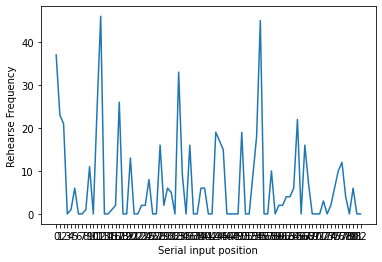

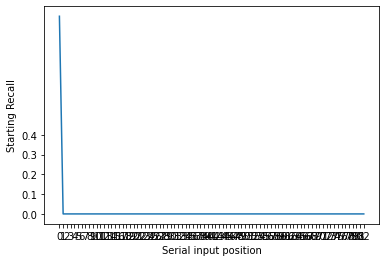

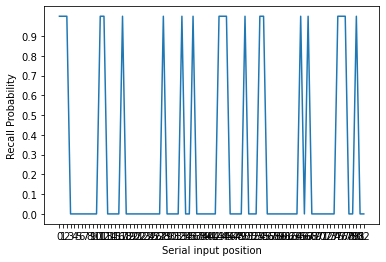

#|Warning: Module WM already exists and cannot be redefined.  Delete it with undefine-module first if you want to redefine it. |#
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0 NIL
     0.050   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
     0.050   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0
     0.185   VISION                 SET-BUFFER-CHUNK VISUAL TEXT0
     0.235   PROCEDURAL             PRODUCTION-FIRED ATTEND-WORD
     0.735   PROCEDURAL             PRODUCTION-FIRED HIGH-SECOND
     0.935   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK0
     0.985   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
     1.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     1.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION1 NIL
  

    16.761   PROCEDURAL             PRODUCTION-FIRED REPLACE-FIRST
    16.961   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK17
    17.011   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
    17.061   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    17.273   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM17
    17.387   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    17.387   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION18 NIL
    17.472   VISION                 SET-BUFFER-CHUNK VISUAL TEXT18 NIL
    17.673   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"negative318"
    17.723   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    17.873   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK18
    17.923   PROCEDURAL             PRODUCTION-FIRED REPLACE-SECOND
    18.123   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK19
    18.173 

    33.960   PROCEDURAL             PRODUCTION-FIRED HARVEST
    34.010   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    34.813   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM9
    34.863   PROCEDURAL             PRODUCTION-FIRED HARVEST
    34.913   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    37.255   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM18
    37.305   PROCEDURAL             PRODUCTION-FIRED HARVEST
    37.355   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    38.006   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM17
    38.056   PROCEDURAL             PRODUCTION-FIRED HARVEST
    38.106   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    40.824   DECLARATIVE            RETRIEVAL-FAILURE
    40.824   ------                 Stopped because no events left to process
#|Warning: Module WM already exists and cannot be redefined.  Delete it with undefine-module first if you want to redefine it. |#
     0.000   GOAL                   S

    16.926   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK16
    17.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    17.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION17 NIL
    17.084   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM1
    17.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT17 NIL
    17.484   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral132"
    17.534   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    17.684   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK17
    17.734   PROCEDURAL             PRODUCTION-FIRED REPLACE-THIRD
    17.934   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK18
    17.984   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
    18.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    18.000   VISION

#|Warning: Module WM already exists and cannot be redefined.  Delete it with undefine-module first if you want to redefine it. |#
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0 NIL
     0.050   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
     0.050   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0
     0.185   VISION                 SET-BUFFER-CHUNK VISUAL TEXT0
     0.235   PROCEDURAL             PRODUCTION-FIRED ATTEND-WORD
     0.735   PROCEDURAL             PRODUCTION-FIRED HIGH-FOURTH
     0.935   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK0
     0.985   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
     1.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     1.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION1 NIL
  

    14.476   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION15 NIL
    14.531   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"positive334"
    14.561   VISION                 SET-BUFFER-CHUNK VISUAL TEXT15 NIL
    14.581   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    14.731   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK14
    15.476   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    15.476   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION16 NIL
    15.556   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM6
    15.561   VISION                 SET-BUFFER-CHUNK VISUAL TEXT16 NIL
    15.956   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"negative478"
    16.006   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    16.156   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK15
    16.206   PROCEDURAL             PRODUC

    27.588   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM20
    27.988   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"positive868"
    28.038   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    28.188   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK31
    28.476   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    28.476   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION29 NIL
    28.561   VISION                 SET-BUFFER-CHUNK VISUAL TEXT29 NIL
    28.785   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM27
    29.185   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"positive265"
    29.235   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    29.385   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK32
    29.476   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
   

     7.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT7 NIL
     7.203   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM6
     7.603   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"negative478"
     7.653   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
     7.803   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK8
     8.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     8.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION8 NIL
     8.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT8 NIL
     8.158   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM1
     8.558   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral132"
     8.608   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
     8.758   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK9
     9.000   ------                 Stopped because time limit reached

    21.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT21 NIL
    21.317   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"positive868"
    21.367   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    21.517   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK26
    21.567   PROCEDURAL             PRODUCTION-FIRED REPLACE-THIRD
    21.767   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK27
    21.817   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
    21.867   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    22.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    22.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION22 NIL
    22.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT22 NIL
    22.115   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM20
    22.515   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"positive868"

    42.496   PROCEDURAL             PRODUCTION-FIRED HARVEST
    42.546   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    45.264   DECLARATIVE            RETRIEVAL-FAILURE
    45.264   ------                 Stopped because no events left to process
#|Warning: Module WM already exists and cannot be redefined.  Delete it with undefine-module first if you want to redefine it. |#
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0 NIL
     0.050   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
     0.050   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0
     0.185   VISION                 SET-BUFFER-CHUNK VISUAL TEXT0
     0.235   PROCEDURAL             PRODUCTION-FIRED ATTEND-WORD
     0.735   PROCEDURAL             PRODUCTION-FIRED HIGH-FOURTH
     0.935   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK0
     0.985   PROCEDURAL          

    14.556   VISION                 SET-BUFFER-CHUNK VISUAL TEXT15 NIL
    14.697   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral399"
    14.747   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    14.897   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK16
    14.947   PROCEDURAL             PRODUCTION-FIRED REPLACE-FOURTH
    15.147   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK17
    15.197   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
    15.247   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    15.471   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    15.471   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION16 NIL
    15.556   VISION                 SET-BUFFER-CHUNK VISUAL TEXT16 NIL
    15.636   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM4
    16.036   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"positive334"


    29.606   PROCEDURAL             PRODUCTION-FIRED START-RECALL
    29.656   PROCEDURAL             PRODUCTION-FIRED CHOOSE-FIRST
    29.706   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-FIRST
    29.861   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM27
    29.911   PROCEDURAL             PRODUCTION-FIRED DUMP-IT
"positive265"
    29.961   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-SECOND
    30.273   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM20
    30.323   PROCEDURAL             PRODUCTION-FIRED DUMP-IT
"positive868"
    30.373   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-THIRD
    31.626   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM28
    31.676   PROCEDURAL             PRODUCTION-FIRED DUMP-IT
"neutral742"
    31.726   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-FOURTH
    32.370   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM15
    32.420   PROCEDURAL             PRODUCTION-FIRED DUMP-IT
"positive361"
    32.470   PR

    11.002   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    11.152   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK10
    11.202   PROCEDURAL             PRODUCTION-FIRED REPLACE-THIRD
    11.402   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK11
    11.452   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
    11.477   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    11.477   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION12 NIL
    11.502   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    11.562   VISION                 SET-BUFFER-CHUNK VISUAL TEXT12 NIL
    11.876   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM1
    12.276   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral132"
    12.326   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    12.476   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK12
    12.477  

    25.477   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    25.477   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION26 NIL
    25.562   VISION                 SET-BUFFER-CHUNK VISUAL TEXT26 NIL
    26.008   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM24
    26.408   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral941"
    26.458   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    26.477   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    26.477   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION27 NIL
    26.562   VISION                 SET-BUFFER-CHUNK VISUAL TEXT27 NIL
    26.608   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK32
    27.477   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#


     8.461   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     8.461   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION9 NIL
     8.541   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK8
     8.546   VISION                 SET-BUFFER-CHUNK VISUAL TEXT9 NIL
     8.797   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM4
     9.197   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"positive334"
     9.247   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
     9.397   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK9
     9.461   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     9.461   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION10 NIL
     9.546   VISION                 SET-BUFFER-CHUNK VISUAL TEXT10 NIL
     9.615   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL 

    23.494   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM14
    23.546   VISION                 SET-BUFFER-CHUNK VISUAL TEXT24 NIL
    23.894   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral672"
    23.944   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    24.094   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK29
    24.144   PROCEDURAL             PRODUCTION-FIRED REPLACE-FOURTH
    24.344   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK30
    24.394   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
    24.444   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    24.461   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    24.461   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION25 NIL
    24.546   VISION                 SET-BUFFER-CHUNK VISUAL TEXT25 NIL
    24.573   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM14
    24.9

     4.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION4 NIL
     4.024   PROCEDURAL             PRODUCTION-FIRED HIGH-SECOND
     4.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT4 NIL
     4.224   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK4
     4.274   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
     4.324   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
     4.824   PROCEDURAL             PRODUCTION-FIRED HIGH-THIRD
     5.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     5.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION5 NIL
     5.024   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK5
     5.074   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
     5.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT5 NIL
     5.124   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
     5.301   D

#|Warning: run-time must be a number greater than zero. |#
    22.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION22 NIL
    22.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT22 NIL
    22.094   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK23
    22.453   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM15
    22.853   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"positive361"
    22.903   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    23.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    23.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION23 NIL
    23.053   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK24
    23.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT23 NIL
    23.465   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM9
    23.865   PROCEDURAL             PRODUCTION-FIRED REHEARSE

     4.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     4.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION4 NIL
     4.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT4 NIL
     4.120   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK4
     4.170   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
     4.220   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
     4.720   PROCEDURAL             PRODUCTION-FIRED HIGH-SECOND
     4.920   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK5
     4.970   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
     5.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     5.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION5 NIL
     5.020   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
     5.085   VISIO

    18.736   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK22
    19.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    19.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION19 NIL
    19.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT19 NIL
    19.799   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM16
    20.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    20.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION20 NIL
    20.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT20 NIL
    20.199   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral725"
    20.249   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    20.399   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK23
    20.449   PROCEDURAL             PRODUCTION-FIRED REPLAC

#|Warning: Module WM already exists and cannot be redefined.  Delete it with undefine-module first if you want to redefine it. |#
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0 NIL
     0.050   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
     0.050   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0
     0.185   VISION                 SET-BUFFER-CHUNK VISUAL TEXT0
     0.235   PROCEDURAL             PRODUCTION-FIRED ATTEND-WORD
     0.735   PROCEDURAL             PRODUCTION-FIRED HIGH-FOURTH
     0.935   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK0
     0.985   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
     1.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     1.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION1 NIL
  

    15.018   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral704"
    15.068   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
    15.218   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK16
    15.323   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM0
    15.407   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    15.407   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION16 NIL
    15.492   VISION                 SET-BUFFER-CHUNK VISUAL TEXT16 NIL
    15.723   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral399"
    15.773   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    15.923   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK17
    15.973   PROCEDURAL             PRODUCTION-FIRED REPLACE-SECOND
    16.173   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK18
    16.223   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
 

    29.680   PROCEDURAL             PRODUCTION-FIRED CHOOSE-SECOND
    29.730   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-SECOND
    29.947   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM16
    29.997   PROCEDURAL             PRODUCTION-FIRED DUMP-IT
"neutral725"
    30.047   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-THIRD
    30.191   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM8
    30.241   PROCEDURAL             PRODUCTION-FIRED DUMP-IT
"neutral704"
    30.291   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-FOURTH
    30.611   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM20
    30.661   PROCEDURAL             PRODUCTION-FIRED DUMP-IT
"positive868"
    30.711   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    31.311   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM1
    31.361   PROCEDURAL             PRODUCTION-FIRED HARVEST
    31.411   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    33.742   DECLARATIVE            SET-B

#|Warning: run-time must be a number greater than zero. |#
    14.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION14 NIL
    14.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT14 NIL
    14.160   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM6
    14.560   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"negative478"
    14.610   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
    14.760   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK16
    15.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    15.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION15 NIL
    15.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT15 NIL
    15.595   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM10
    15.995   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral477"
    16.000   ------                 Stopped because 

    28.129   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM11
    28.529   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"positive375"
    28.579   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    28.729   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK36
    29.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    29.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION29 NIL
    29.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT29 NIL
    29.191   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM27
    29.591   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"positive265"
    29.641   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    29.791   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK37
    30.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
   

     7.719   PROCEDURAL             PRODUCTION-FIRED REPLACE-SECOND
     7.919   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK11
     7.969   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
     8.019   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
     8.019   ------                 Stopped because no events left to process
#|Warning: run-time must be a number greater than zero. |#
     8.019   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION12 NIL
     8.104   VISION                 SET-BUFFER-CHUNK VISUAL TEXT12 NIL
     8.154   PROCEDURAL             PRODUCTION-FIRED REPLACE-FOURTH
     8.354   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK12
     8.404   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
     8.454   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
     8.454   ------                 Stopped because no events left to process
#|Warning: run-time must be a number greater than zero. |#
     8.454   VISIO

    15.749   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK29
    15.799   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
    15.849   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    15.849   ------                 Stopped because no events left to process
#|Warning: run-time must be a number greater than zero. |#
    15.934   ------                 Stopped because no events left to process
    15.934   GOAL                   SET-BUFFER-CHUNK GOAL STARTRECALL NIL
    15.984   PROCEDURAL             PRODUCTION-FIRED START-RECALL
    16.034   PROCEDURAL             PRODUCTION-FIRED CHOOSE-FIRST
    16.084   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-FIRST
    17.045   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM25
    17.095   PROCEDURAL             PRODUCTION-FIRED DUMP-IT
"positive501"
    17.145   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-SECOND
    18.436   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM28
    18.486   PROCEDURA

     4.464   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     4.464   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION5 NIL
     4.549   VISION                 SET-BUFFER-CHUNK VISUAL TEXT5 NIL
     4.599   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM0
     4.999   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral399"
     5.049   PROCEDURAL             PRODUCTION-FIRED SKIP-SECOND
     5.099   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
     5.199   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK5
     5.464   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     5.464   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION6 NIL
     5.549   VISION                 SET-BUFFER-CHUNK VISUAL TEXT6 NIL
     5.778   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM4
  

    20.464   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION21 NIL
    20.538   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM18
    20.549   VISION                 SET-BUFFER-CHUNK VISUAL TEXT21 NIL
    20.938   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral397"
    20.988   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    21.138   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK24
    21.188   PROCEDURAL             PRODUCTION-FIRED REPLACE-THIRD
    21.388   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK25
    21.438   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
    21.464   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    21.464   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION22 NIL
    21.488   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    21.549   VISION                 SET-BUFFER-CHUNK VISUAL

     4.309   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
     4.359   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
     4.474   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     4.474   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION5 NIL
     4.559   VISION                 SET-BUFFER-CHUNK VISUAL TEXT5 NIL
     4.643   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM0
     5.043   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral399"
     5.093   PROCEDURAL             PRODUCTION-FIRED SKIP-SECOND
     5.143   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
     5.243   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK5
     5.474   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     5.474   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION6 NIL
     5.

    19.559   VISION                 SET-BUFFER-CHUNK VISUAL TEXT20 NIL
    19.753   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"negative318"
    19.803   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    19.953   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK21
    20.003   PROCEDURAL             PRODUCTION-FIRED REPLACE-FOURTH
    20.203   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK22
    20.253   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
    20.303   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    20.474   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    20.474   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION21 NIL
    20.515   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM13
    20.559   VISION                 SET-BUFFER-CHUNK VISUAL TEXT21 NIL
    20.915   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"positive634

    40.398   PROCEDURAL             PRODUCTION-FIRED HARVEST
    40.448   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    41.667   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM21
    41.717   PROCEDURAL             PRODUCTION-FIRED HARVEST
    41.767   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    42.173   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM4
    42.223   PROCEDURAL             PRODUCTION-FIRED HARVEST
    42.273   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    44.991   DECLARATIVE            RETRIEVAL-FAILURE
    44.991   ------                 Stopped because no events left to process
#|Warning: Module WM already exists and cannot be redefined.  Delete it with undefine-module first if you want to redefine it. |#
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0 NIL
     0.050   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD

    14.339   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK17
    14.389   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
    14.439   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    14.480   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    14.480   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION15 NIL
    14.565   VISION                 SET-BUFFER-CHUNK VISUAL TEXT15 NIL
    14.693   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM14
    15.093   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral672"
    15.143   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    15.293   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK18
    15.480   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    15.480   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION16 

    30.490   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-THIRD
    31.852   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM27
    31.902   PROCEDURAL             PRODUCTION-FIRED DUMP-IT
"positive265"
    31.952   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-FOURTH
    33.303   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM29
    33.353   PROCEDURAL             PRODUCTION-FIRED DUMP-IT
"negative460"
    33.403   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    33.751   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM0
    33.801   PROCEDURAL             PRODUCTION-FIRED HARVEST
    33.851   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    34.809   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM4
    34.859   PROCEDURAL             PRODUCTION-FIRED HARVEST
    34.909   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    36.203   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM13
    36.253   PROCEDURAL             PRODUCTION-FIRED HARV

    14.618   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral477"
    14.668   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    14.818   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK17
    14.984   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM8
    15.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    15.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION15 NIL
    15.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT15 NIL
    15.384   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral704"
    15.434   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    15.584   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK18
    15.634   PROCEDURAL             PRODUCTION-FIRED REPLACE-FIRST
    15.834   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK19
    15.884   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
  

    29.773   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK33
    30.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    30.109   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM16
    30.109   ------                 Stopped because no events left to process
    30.109   GOAL                   SET-BUFFER-CHUNK GOAL STARTRECALL NIL
    30.159   PROCEDURAL             PRODUCTION-FIRED START-RECALL
    30.209   PROCEDURAL             PRODUCTION-FIRED CHOOSE-FIRST
    30.259   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-FIRST
    30.362   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM15
    30.412   PROCEDURAL             PRODUCTION-FIRED DUMP-IT
"positive361"
    30.462   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-SECOND
    30.631   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM16
    30.681   PROCEDURAL             PRODUCTION-FIRED DUMP-IT
"neutral725"
    30.731   PROCEDU

     9.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT9 NIL
     9.234   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM6
     9.634   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"negative478"
     9.684   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
     9.834   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK11
    10.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    10.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION10 NIL
    10.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT10 NIL
    10.503   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM8
    10.903   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral704"
    10.953   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    11.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    11

    26.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    26.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION26 NIL
    26.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT26 NIL
    26.161   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM25
    26.561   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"positive501"
    26.611   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    26.761   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK30
    27.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    27.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION27 NIL
    27.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT27 NIL
    27.803   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM24
    28.000   ------                 Stopped because time l

    10.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION10 NIL
    10.083   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"negative478"
    10.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT10 NIL
    10.133   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
    10.283   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK10
    10.597   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM0
    10.997   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral399"
    11.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    11.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION11 NIL
    11.047   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    11.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT11 NIL
    11.197   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK11
    11.484   DECLARATIVE            SET-BUF

"negative450"
    25.781   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    25.931   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK30
    26.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    26.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION26 NIL
    26.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT26 NIL
    26.253   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM14
    26.653   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral672"
    26.703   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    26.853   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK31
    27.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    27.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION27 NIL
    27.085   VISION                 SET-BUFFER-C

     4.439   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION5 NIL
     4.488   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM0
     4.524   VISION                 SET-BUFFER-CHUNK VISUAL TEXT5 NIL
     4.888   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral399"
     4.938   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
     5.088   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK5
     5.439   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     5.439   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION6 NIL
     5.524   VISION                 SET-BUFFER-CHUNK VISUAL TEXT6 NIL
     5.588   PROCEDURAL             PRODUCTION-FIRED HIGH-THIRD
     5.788   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK6
     5.838   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
     5.888   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WO

    11.243   PROCEDURAL             PRODUCTION-FIRED REPLACE-THIRD
    11.443   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK19
    11.493   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
    11.543   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    11.543   ------                 Stopped because no events left to process
#|Warning: run-time must be a number greater than zero. |#
    11.543   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION20 NIL
    11.628   VISION                 SET-BUFFER-CHUNK VISUAL TEXT20 NIL
    11.678   PROCEDURAL             PRODUCTION-FIRED REPLACE-SECOND
    11.878   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK20
    11.928   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
    11.978   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    11.978   ------                 Stopped because no events left to process
#|Warning: run-time must be a number greater than zero. |#
    11.978   VISION

    28.583   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    30.243   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM9
    30.293   PROCEDURAL             PRODUCTION-FIRED HARVEST
    30.343   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    32.153   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM26
    32.203   PROCEDURAL             PRODUCTION-FIRED HARVEST
    32.253   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    34.095   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM18
    34.145   PROCEDURAL             PRODUCTION-FIRED HARVEST
    34.195   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    36.237   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM29
    36.287   PROCEDURAL             PRODUCTION-FIRED HARVEST
    36.337   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    37.834   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM27
    37.884   PROCEDURAL             PRODUCTION-FIRED HARVEST
    37.934   PROCEDURAL             

#|Warning: run-time must be a number greater than zero. |#
     5.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION5 NIL
     5.015   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK5
     5.065   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
     5.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT5 NIL
     5.115   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
     5.286   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM0
     5.686   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral399"
     5.736   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
     5.886   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK6
     6.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     6.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION6 NIL
     6.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT6 NIL
   

    23.971   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    24.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    24.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION24 NIL
    24.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT24 NIL
    24.190   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM23
    24.590   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"negative450"
    24.640   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    24.790   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK28
    24.931   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM16
    25.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    25.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION25 NIL
    25.085   VISION                 SET-BUFFER-CHUNK VISUAL T

     4.413   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
     4.413   ------                 Stopped because no events left to process
#|Warning: run-time must be a number greater than zero. |#
     4.413   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION5 NIL
     4.498   VISION                 SET-BUFFER-CHUNK VISUAL TEXT5 NIL
     4.998   PROCEDURAL             PRODUCTION-FIRED HIGH-FOURTH
     5.198   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK5
     5.248   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
     5.298   PROCEDURAL             PRODUCTION-FIRED SKIP-FIRST
     5.348   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
     5.413   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     5.413   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION6 NIL
     5.498   VISION                 SET-BUFFER-CHUNK VISUAL TEXT6 NIL
     5.546 

    21.413   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    21.413   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION22 NIL
    21.498   VISION                 SET-BUFFER-CHUNK VISUAL TEXT22 NIL
    21.541   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral725"
    21.591   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    21.741   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK27
    21.791   PROCEDURAL             PRODUCTION-FIRED REPLACE-FOURTH
    21.991   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK28
    22.041   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
    22.091   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    22.187   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM10
    22.413   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    22.413   VISION

#|Warning: Module WM already exists and cannot be redefined.  Delete it with undefine-module first if you want to redefine it. |#
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0 NIL
     0.050   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
     0.050   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0
     0.185   VISION                 SET-BUFFER-CHUNK VISUAL TEXT0
     0.235   PROCEDURAL             PRODUCTION-FIRED ATTEND-WORD
     0.735   PROCEDURAL             PRODUCTION-FIRED HIGH-FOURTH
     0.935   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK0
     0.985   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
     1.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     1.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION1 NIL
  

#|Warning: run-time must be a number greater than zero. |#
    17.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION17 NIL
    17.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT17 NIL
    17.894   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM14
    18.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    18.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION18 NIL
    18.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT18 NIL
    18.294   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral672"
    18.344   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    18.494   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK20
    18.544   PROCEDURAL             PRODUCTION-FIRED REPLACE-FOURTH
    18.744   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK21
    18.794   PROCEDURAL             PRODUCTION-FIRED CREATE-TO

#|Warning: Module WM already exists and cannot be redefined.  Delete it with undefine-module first if you want to redefine it. |#
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0 NIL
     0.050   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
     0.050   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0
     0.185   VISION                 SET-BUFFER-CHUNK VISUAL TEXT0
     0.235   PROCEDURAL             PRODUCTION-FIRED ATTEND-WORD
     0.735   PROCEDURAL             PRODUCTION-FIRED HIGH-SECOND
     0.935   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK0
     0.985   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
     1.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     1.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION1 NIL
  

    11.731   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION19 NIL
    11.816   VISION                 SET-BUFFER-CHUNK VISUAL TEXT19 NIL
    11.866   PROCEDURAL             PRODUCTION-FIRED REPLACE-THIRD
    12.066   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK19
    12.116   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
    12.166   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    12.166   ------                 Stopped because no events left to process
#|Warning: run-time must be a number greater than zero. |#
    12.166   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION20 NIL
    12.251   VISION                 SET-BUFFER-CHUNK VISUAL TEXT20 NIL
    12.301   PROCEDURAL             PRODUCTION-FIRED REPLACE-SECOND
    12.501   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK20
    12.551   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
    12.601   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW

    54.131   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    55.807   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM23
    55.857   PROCEDURAL             PRODUCTION-FIRED HARVEST
    55.907   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    57.285   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM27
    57.335   PROCEDURAL             PRODUCTION-FIRED HARVEST
    57.385   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    59.324   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM25
    59.374   PROCEDURAL             PRODUCTION-FIRED HARVEST
    59.424   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    60.117   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM0
    60.167   PROCEDURAL             PRODUCTION-FIRED HARVEST
    60.217   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    61.269   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM22
    61.319   PROCEDURAL             PRODUCTION-FIRED HARVEST
    61.369   PROCEDURAL             

     9.633   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK12
     9.683   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
     9.733   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
     9.733   ------                 Stopped because no events left to process
#|Warning: run-time must be a number greater than zero. |#
     9.733   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION12 NIL
     9.818   VISION                 SET-BUFFER-CHUNK VISUAL TEXT12 NIL
     9.868   PROCEDURAL             PRODUCTION-FIRED REPLACE-FOURTH
    10.068   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK13
    10.118   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
    10.168   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    10.168   ------                 Stopped because no events left to process
#|Warning: run-time must be a number greater than zero. |#
    10.168   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION13

    15.958   PROCEDURAL             PRODUCTION-FIRED REPLACE-SECOND
    16.158   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK27
    16.208   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
    16.258   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    16.258   ------                 Stopped because no events left to process
#|Warning: run-time must be a number greater than zero. |#
    16.258   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION27 NIL
    16.343   VISION                 SET-BUFFER-CHUNK VISUAL TEXT27 NIL
    16.393   PROCEDURAL             PRODUCTION-FIRED REPLACE-FIRST
    16.593   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK28
    16.643   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
    16.693   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    16.693   ------                 Stopped because no events left to process
#|Warning: run-time must be a number greater than zero. |#
    16.693   VISION

#|Warning: Module WM already exists and cannot be redefined.  Delete it with undefine-module first if you want to redefine it. |#
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0 NIL
     0.050   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
     0.050   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0
     0.185   VISION                 SET-BUFFER-CHUNK VISUAL TEXT0
     0.235   PROCEDURAL             PRODUCTION-FIRED ATTEND-WORD
     0.735   PROCEDURAL             PRODUCTION-FIRED HIGH-FOURTH
     0.935   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK0
     0.985   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
     1.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     1.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION1 NIL
  

    15.387   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION16 NIL
    15.426   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    15.472   VISION                 SET-BUFFER-CHUNK VISUAL TEXT16 NIL
    15.635   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM14
    16.035   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral672"
    16.085   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    16.235   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK20
    16.370   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM1
    16.387   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    16.387   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION17 NIL
    16.472   VISION                 SET-BUFFER-CHUNK VISUAL TEXT17 NIL
    16.770   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral132"
    16.820   PROCEDURAL             PRODUCTI

"neutral132"
    30.168   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-THIRD
    31.510   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM23
    31.560   PROCEDURAL             PRODUCTION-FIRED DUMP-IT
"negative450"
    31.610   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-FOURTH
    34.328   DECLARATIVE            RETRIEVAL-FAILURE
    34.328   ------                 Stopped because no events left to process
#|Warning: Module WM already exists and cannot be redefined.  Delete it with undefine-module first if you want to redefine it. |#
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0 NIL
     0.050   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
     0.050   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0
     0.185   VISION                 SET-BUFFER-CHUNK VISUAL TEXT0
     0.235   PROCEDURAL             PRODUCTION-FIRED ATTEND-

    13.652   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK19
    13.702   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
    13.752   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    13.752   ------                 Stopped because no events left to process
#|Warning: run-time must be a number greater than zero. |#
    13.752   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION20 NIL
    13.837   VISION                 SET-BUFFER-CHUNK VISUAL TEXT20 NIL
    13.887   PROCEDURAL             PRODUCTION-FIRED REPLACE-THIRD
    14.087   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK20
    14.137   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
    14.187   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    14.187   ------                 Stopped because no events left to process
#|Warning: run-time must be a number greater than zero. |#
    14.187   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION21 

    33.408   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM9
    33.458   PROCEDURAL             PRODUCTION-FIRED HARVEST
    33.508   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    35.409   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM24
    35.459   PROCEDURAL             PRODUCTION-FIRED HARVEST
    35.509   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    37.622   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM11
    37.672   PROCEDURAL             PRODUCTION-FIRED HARVEST
    37.722   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    39.353   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM27
    39.403   PROCEDURAL             PRODUCTION-FIRED HARVEST
    39.453   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    40.739   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM29
    40.789   PROCEDURAL             PRODUCTION-FIRED HARVEST
    40.839   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    42.795   DECLARATIVE            

     5.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION5 NIL
     5.012   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
     5.062   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
     5.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT5 NIL
     5.224   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM4
     5.624   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"positive334"
     5.674   PROCEDURAL             PRODUCTION-FIRED SKIP-SECOND
     5.724   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
     5.824   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK5
     6.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     6.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION6 NIL
     6.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT6 NIL
     6.157   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITE

    22.583   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    22.733   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK27
    22.848   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM15
    23.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    23.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION23 NIL
    23.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT23 NIL
    23.248   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"positive361"
    23.298   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    23.448   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK28
    23.498   PROCEDURAL             PRODUCTION-FIRED REPLACE-FOURTH
    23.698   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK29
    23.748   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
    23.798   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    23.97

#|Warning: Module WM already exists and cannot be redefined.  Delete it with undefine-module first if you want to redefine it. |#
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0 NIL
     0.050   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
     0.050   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0
     0.185   VISION                 SET-BUFFER-CHUNK VISUAL TEXT0
     0.235   PROCEDURAL             PRODUCTION-FIRED ATTEND-WORD
     0.735   PROCEDURAL             PRODUCTION-FIRED HIGH-SECOND
     0.935   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK0
     0.985   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
     1.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     1.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION1 NIL
  

    17.232   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM14
    17.632   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral672"
    17.682   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    17.832   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK21
    17.917   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM7
    18.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    18.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION18 NIL
    18.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT18 NIL
    18.317   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"positive362"
    18.367   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    18.517   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK22
    18.567   PROCEDURAL             PRODUCTION-FIRED REPLACE-FIRST
    18.767   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK

#|Warning: Module WM already exists and cannot be redefined.  Delete it with undefine-module first if you want to redefine it. |#
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0 NIL
     0.050   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
     0.050   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0
     0.185   VISION                 SET-BUFFER-CHUNK VISUAL TEXT0
     0.235   PROCEDURAL             PRODUCTION-FIRED ATTEND-WORD
     0.735   PROCEDURAL             PRODUCTION-FIRED HIGH-FIRST
     0.935   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK0
     0.985   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
     1.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     1.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION1 NIL
   

    11.233   VISION                 SET-BUFFER-CHUNK VISUAL TEXT19 NIL
    11.283   PROCEDURAL             PRODUCTION-FIRED REPLACE-FOURTH
    11.483   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK19
    11.533   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
    11.583   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    11.583   ------                 Stopped because no events left to process
#|Warning: run-time must be a number greater than zero. |#
    11.583   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION20 NIL
    11.668   VISION                 SET-BUFFER-CHUNK VISUAL TEXT20 NIL
    11.718   PROCEDURAL             PRODUCTION-FIRED REPLACE-FOURTH
    11.918   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK20
    11.968   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
    12.018   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    12.018   ------                 Stopped because no events left to process
#|Warn

    50.795   PROCEDURAL             PRODUCTION-FIRED HARVEST
    50.845   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    52.873   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM28
    52.923   PROCEDURAL             PRODUCTION-FIRED HARVEST
    52.973   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    54.982   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM22
    55.032   PROCEDURAL             PRODUCTION-FIRED HARVEST
    55.082   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    56.738   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM27
    56.788   PROCEDURAL             PRODUCTION-FIRED HARVEST
    56.838   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    58.660   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM25
    58.710   PROCEDURAL             PRODUCTION-FIRED HARVEST
    58.760   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    60.355   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM29
    60.405   PROCEDURAL            

"positive362"
     9.467   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
     9.617   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK12
     9.667   PROCEDURAL             PRODUCTION-FIRED REPLACE-THIRD
     9.867   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK13
     9.917   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
     9.967   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    10.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    10.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION10 NIL
    10.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT10 NIL
    10.143   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM7
    10.543   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"positive362"
    10.593   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    10.743   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK

    27.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION27 NIL
    27.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT27 NIL
    27.282   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM20
    27.682   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"positive868"
    27.732   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    27.882   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK34
    28.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    28.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION28 NIL
    28.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT28 NIL
    28.429   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM13
    28.829   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"positive634"
    28.879   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    29.000   ------                 Stopp

     5.159   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK5
     5.395   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     5.395   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION6 NIL
     5.480   VISION                 SET-BUFFER-CHUNK VISUAL TEXT6 NIL
     5.986   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM2
     6.386   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"positive49"
     6.395   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     6.395   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION7 NIL
     6.436   PROCEDURAL             PRODUCTION-FIRED SKIP-THIRD
     6.480   VISION                 SET-BUFFER-CHUNK VISUAL TEXT7 NIL
     6.486   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
     6.586   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK6
  

    24.117   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM9
    24.395   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    24.395   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION25 NIL
    24.480   VISION                 SET-BUFFER-CHUNK VISUAL TEXT25 NIL
    24.517   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"negative587"
    24.567   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    24.717   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK26
    24.767   PROCEDURAL             PRODUCTION-FIRED REPLACE-FOURTH
    24.967   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK27
    25.017   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
    25.067   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    25.295   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM10
    25.395   ------                 Stopped because time limit reached
#|Warnin

     4.442   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
     4.592   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK4
     5.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     5.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION5 NIL
     5.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT5 NIL
     5.092   PROCEDURAL             PRODUCTION-FIRED HIGH-FOURTH
     5.292   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK5
     5.342   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
     5.392   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
     5.392   ------                 Stopped because no events left to process
#|Warning: run-time must be a number greater than zero. |#
     5.392   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION6 NIL
     5.477   VISION                 SET-BUFFER-CHUNK VISUAL TEXT6 NIL
     5

"negative38"
    21.941   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    22.091   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK26
    22.141   PROCEDURAL             PRODUCTION-FIRED REPLACE-THIRD
    22.341   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK27
    22.391   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
    22.392   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    22.392   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION23 NIL
    22.441   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    22.477   VISION                 SET-BUFFER-CHUNK VISUAL TEXT23 NIL
    22.689   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM21
    23.089   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"negative38"
    23.139   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    23.289   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK2

#|Warning: Module WM already exists and cannot be redefined.  Delete it with undefine-module first if you want to redefine it. |#
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0 NIL
     0.050   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
     0.050   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0
     0.185   VISION                 SET-BUFFER-CHUNK VISUAL TEXT0
     0.235   PROCEDURAL             PRODUCTION-FIRED ATTEND-WORD
     0.735   PROCEDURAL             PRODUCTION-FIRED HIGH-FOURTH
     0.935   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK0
     0.985   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
     1.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     1.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION1 NIL
  

#|Warning: run-time must be a number greater than zero. |#
    12.819   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION19 NIL
    12.904   VISION                 SET-BUFFER-CHUNK VISUAL TEXT19 NIL
    12.954   PROCEDURAL             PRODUCTION-FIRED REPLACE-FOURTH
    13.154   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK19
    13.204   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
    13.254   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    13.254   ------                 Stopped because no events left to process
#|Warning: run-time must be a number greater than zero. |#
    13.254   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION20 NIL
    13.339   VISION                 SET-BUFFER-CHUNK VISUAL TEXT20 NIL
    13.389   PROCEDURAL             PRODUCTION-FIRED REPLACE-THIRD
    13.589   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK20
    13.639   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
    

    54.586   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM12
    54.636   PROCEDURAL             PRODUCTION-FIRED HARVEST
    54.686   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    55.943   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM28
    55.993   PROCEDURAL             PRODUCTION-FIRED HARVEST
    56.043   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    58.176   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM9
    58.226   PROCEDURAL             PRODUCTION-FIRED HARVEST
    58.276   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    59.661   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM24
    59.711   PROCEDURAL             PRODUCTION-FIRED HARVEST
    59.761   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    61.293   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM20
    61.343   PROCEDURAL             PRODUCTION-FIRED HARVEST
    61.393   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    62.233   DECLARATIVE            

    11.003   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    11.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT11 NIL
    11.144   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM5
    11.544   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral410"
    11.594   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    11.744   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK14
    12.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    12.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION12 NIL
    12.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT12 NIL
    12.550   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM9
    12.950   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"negative587"
    13.000   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    13.000   ------                 Stopped because time limit reac

    30.473   GOAL                   SET-BUFFER-CHUNK GOAL STARTRECALL NIL
    30.523   PROCEDURAL             PRODUCTION-FIRED START-RECALL
    30.573   PROCEDURAL             PRODUCTION-FIRED CHOOSE-FIRST
    30.623   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-FIRST
    30.726   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM5
    30.776   PROCEDURAL             PRODUCTION-FIRED DUMP-IT
"neutral410"
    30.826   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-SECOND
    31.651   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM21
    31.701   PROCEDURAL             PRODUCTION-FIRED DUMP-IT
"negative38"
    31.751   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-THIRD
    33.169   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM28
    33.219   PROCEDURAL             PRODUCTION-FIRED DUMP-IT
"neutral742"
    33.269   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-FOURTH
    34.235   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM29
    34.285   PROCED

#|Warning: run-time must be a number greater than zero. |#
     9.334   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION11 NIL
     9.419   VISION                 SET-BUFFER-CHUNK VISUAL TEXT11 NIL
     9.469   PROCEDURAL             PRODUCTION-FIRED REPLACE-SECOND
     9.669   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK11
     9.719   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
     9.769   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
     9.769   ------                 Stopped because no events left to process
#|Warning: run-time must be a number greater than zero. |#
     9.769   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION12 NIL
     9.854   VISION                 SET-BUFFER-CHUNK VISUAL TEXT12 NIL
     9.904   PROCEDURAL             PRODUCTION-FIRED REPLACE-FOURTH
    10.104   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK12
    10.154   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
   

    15.509   VISION                 SET-BUFFER-CHUNK VISUAL TEXT25 NIL
    15.559   PROCEDURAL             PRODUCTION-FIRED REPLACE-SECOND
    15.759   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK25
    15.809   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
    15.859   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    15.859   ------                 Stopped because no events left to process
#|Warning: run-time must be a number greater than zero. |#
    15.859   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION26 NIL
    15.944   VISION                 SET-BUFFER-CHUNK VISUAL TEXT26 NIL
    15.994   PROCEDURAL             PRODUCTION-FIRED REPLACE-SECOND
    16.194   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK26
    16.244   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
    16.294   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    16.294   ------                 Stopped because no events left to process
#|Warn

#|Warning: Module WM already exists and cannot be redefined.  Delete it with undefine-module first if you want to redefine it. |#
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0 NIL
     0.050   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
     0.050   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0
     0.185   VISION                 SET-BUFFER-CHUNK VISUAL TEXT0
     0.235   PROCEDURAL             PRODUCTION-FIRED ATTEND-WORD
     0.735   PROCEDURAL             PRODUCTION-FIRED HIGH-FOURTH
     0.935   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK0
     0.985   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
     1.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     1.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION1 NIL
  

    16.659   PROCEDURAL             PRODUCTION-FIRED REPLACE-SECOND
    16.859   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK20
    16.909   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
    16.959   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    17.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    17.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION17 NIL
    17.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT17 NIL
    17.109   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM10
    17.509   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral477"
    17.559   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    17.709   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK21
    18.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    18.000   VISION

#|Warning: Module WM already exists and cannot be redefined.  Delete it with undefine-module first if you want to redefine it. |#
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0 NIL
     0.050   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
     0.050   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0
     0.185   VISION                 SET-BUFFER-CHUNK VISUAL TEXT0
     0.235   PROCEDURAL             PRODUCTION-FIRED ATTEND-WORD
     0.735   PROCEDURAL             PRODUCTION-FIRED HIGH-FIRST
     0.935   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK0
     0.985   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
     1.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     1.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION1 NIL
   

    16.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT16 NIL
    16.170   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM10
    16.570   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral477"
    16.620   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    16.770   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK18
    16.830   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM0
    17.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    17.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION17 NIL
    17.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT17 NIL
    17.230   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral399"
    17.280   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    17.430   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK19
    17.480   PROCEDURAL             PRODUCTION-FIRED REPLACE-FOUR

#|Warning: Module WM already exists and cannot be redefined.  Delete it with undefine-module first if you want to redefine it. |#
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0 NIL
     0.050   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
     0.050   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0
     0.185   VISION                 SET-BUFFER-CHUNK VISUAL TEXT0
     0.235   PROCEDURAL             PRODUCTION-FIRED ATTEND-WORD
     0.735   PROCEDURAL             PRODUCTION-FIRED HIGH-FOURTH
     0.935   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK0
     0.985   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
     1.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     1.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION1 NIL
  

    15.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION15 NIL
    15.059   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM14
    15.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT15 NIL
    15.459   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral672"
    15.509   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    15.659   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK19
    15.709   PROCEDURAL             PRODUCTION-FIRED REPLACE-FOURTH
    15.909   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK20
    15.959   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
    16.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    16.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION16 NIL
    16.009   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    16.085   VISION                 SET-BUFFER-CHUNK VISUA

    38.847   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    39.636   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM15
    39.686   PROCEDURAL             PRODUCTION-FIRED HARVEST
    39.736   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    41.194   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM13
    41.244   PROCEDURAL             PRODUCTION-FIRED HARVEST
    41.294   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    43.578   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM21
    43.628   PROCEDURAL             PRODUCTION-FIRED HARVEST
    43.678   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    44.487   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM10
    44.537   PROCEDURAL             PRODUCTION-FIRED HARVEST
    44.587   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    46.642   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM26
    46.692   PROCEDURAL             PRODUCTION-FIRED HARVEST
    46.742   PROCEDURAL            

    11.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT11 NIL
    11.384   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"positive334"
    11.434   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    11.584   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK12
    11.634   PROCEDURAL             PRODUCTION-FIRED REPLACE-THIRD
    11.834   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK13
    11.884   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
    11.934   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    12.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    12.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION12 NIL
    12.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT12 NIL
    12.281   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM3
    12.681   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"negative163"


    26.593   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM17
    26.993   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"negative318"
    27.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    27.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION27 NIL
    27.043   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    27.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT27 NIL
    27.193   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK35
    27.675   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM18
    28.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    28.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION28 NIL
    28.075   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral397"
    28.085   VISION                 SET-BUFFER-CHUNK

     5.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT5 NIL
     5.390   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral399"
     5.440   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
     5.590   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK5
     6.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     6.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION6 NIL
     6.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT6 NIL
     6.090   PROCEDURAL             PRODUCTION-FIRED HIGH-SECOND
     6.290   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK6
     6.340   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
     6.390   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
     6.390   ------                 Stopped because no events left to process
#|Warning: run-time must be a number greater than zero. |#
     6.390   VISIO

#|Warning: run-time must be a number greater than zero. |#
    22.390   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION23 NIL
    22.475   VISION                 SET-BUFFER-CHUNK VISUAL TEXT23 NIL
    22.542   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM1
    22.942   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral132"
    22.992   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    23.142   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK25
    23.390   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    23.390   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION24 NIL
    23.475   VISION                 SET-BUFFER-CHUNK VISUAL TEXT24 NIL
    23.490   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM18
    23.890   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral397"
    23.940   PROCEDURAL             PRODUCTION-FIRED 

     4.497   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
     4.497   ------                 Stopped because no events left to process
#|Warning: run-time must be a number greater than zero. |#
     4.497   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION5 NIL
     4.582   VISION                 SET-BUFFER-CHUNK VISUAL TEXT5 NIL
     5.082   PROCEDURAL             PRODUCTION-FIRED HIGH-FIRST
     5.282   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK5
     5.332   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
     5.382   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
     5.497   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     5.497   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION6 NIL
     5.582   VISION                 SET-BUFFER-CHUNK VISUAL TEXT6 NIL
     5.635   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM5
     6.0

    20.497   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION21 NIL
    20.582   VISION                 SET-BUFFER-CHUNK VISUAL TEXT21 NIL
    20.663   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM13
    21.063   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"positive634"
    21.113   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    21.263   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK24
    21.497   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    21.497   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION22 NIL
    21.582   VISION                 SET-BUFFER-CHUNK VISUAL TEXT22 NIL
    21.869   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM20
    22.269   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"positive868"
    22.319   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    22.469   IMAGINAL               SET-B

#|Warning: run-time must be a number greater than zero. |#
     5.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION5 NIL
     5.044   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
     5.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT5 NIL
     5.242   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM4
     5.642   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"positive334"
     5.692   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
     5.842   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK5
     6.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     6.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION6 NIL
     6.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT6 NIL
     6.099   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM1
     6.499   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"ne

    12.719   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION20 NIL
    12.804   VISION                 SET-BUFFER-CHUNK VISUAL TEXT20 NIL
    12.854   PROCEDURAL             PRODUCTION-FIRED REPLACE-THIRD
    13.054   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK20
    13.104   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
    13.154   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    13.154   ------                 Stopped because no events left to process
#|Warning: run-time must be a number greater than zero. |#
    13.154   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION21 NIL
    13.239   VISION                 SET-BUFFER-CHUNK VISUAL TEXT21 NIL
    13.289   PROCEDURAL             PRODUCTION-FIRED REPLACE-THIRD
    13.489   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK21
    13.539   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
    13.589   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-

    56.053   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM29
    56.103   PROCEDURAL             PRODUCTION-FIRED HARVEST
    56.153   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    57.686   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM26
    57.736   PROCEDURAL             PRODUCTION-FIRED HARVEST
    57.786   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    58.992   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM27
    59.042   PROCEDURAL             PRODUCTION-FIRED HARVEST
    59.092   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    60.760   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM17
    60.810   PROCEDURAL             PRODUCTION-FIRED HARVEST
    60.860   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    61.693   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM1
    61.743   PROCEDURAL             PRODUCTION-FIRED HARVEST
    61.793   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    62.754   DECLARATIVE            

    10.277   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM1
    10.418   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    10.418   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION11 NIL
    10.503   VISION                 SET-BUFFER-CHUNK VISUAL TEXT11 NIL
    10.677   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral132"
    10.727   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    10.877   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK12
    10.927   PROCEDURAL             PRODUCTION-FIRED REPLACE-SECOND
    11.127   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK13
    11.177   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
    11.227   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    11.418   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    11.418   VISION 

    24.128   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    24.278   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK26
    24.418   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    24.418   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION25 NIL
    24.503   VISION                 SET-BUFFER-CHUNK VISUAL TEXT25 NIL
    24.652   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM11
    25.052   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"positive375"
    25.102   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    25.252   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK27
    25.418   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    25.418   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION26 NIL
    25.503   VISION                 SET-BUFFER-CHUNK VISUAL T

     4.851   PROCEDURAL             PRODUCTION-FIRED HIGH-THIRD
     5.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     5.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION5 NIL
     5.051   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK5
     5.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT5 NIL
     5.101   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
     5.151   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
     5.651   PROCEDURAL             PRODUCTION-FIRED HIGH-FIRST
     5.851   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK6
     5.901   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
     5.951   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
     6.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     6.000   VISION                 SET-BUFFE

#|Warning: run-time must be a number greater than zero. |#
    24.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION24 NIL
    24.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT24 NIL
    24.248   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM23
    24.648   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"negative450"
    24.698   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    24.848   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK28
    24.921   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM11
    25.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    25.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION25 NIL
    25.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT25 NIL
    25.321   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"positive375"
    25.371   PROCEDURAL             PRODUCTION-FIR

     5.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     5.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION5 NIL
     5.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT5 NIL
     5.159   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral399"
     5.209   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
     5.359   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK5
     5.859   PROCEDURAL             PRODUCTION-FIRED HIGH-FIRST
     6.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     6.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION6 NIL
     6.059   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK6
     6.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT6 NIL
     6.109   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
     

    24.516   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    24.666   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK26
    24.716   PROCEDURAL             PRODUCTION-FIRED REPLACE-FOURTH
    24.916   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK27
    24.966   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
    25.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    25.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION25 NIL
    25.016   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    25.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT25 NIL
    25.227   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM23
    25.627   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"negative450"
    25.677   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    25.827   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK28
    26.00

     4.302   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK4
     4.352   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
     4.402   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
     4.402   ------                 Stopped because no events left to process
#|Warning: run-time must be a number greater than zero. |#
     4.402   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION5 NIL
     4.487   VISION                 SET-BUFFER-CHUNK VISUAL TEXT5 NIL
     4.987   PROCEDURAL             PRODUCTION-FIRED HIGH-FOURTH
     5.187   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK5
     5.237   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
     5.287   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
     5.402   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     5.402   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION6 NIL
     5.487 

    22.487   VISION                 SET-BUFFER-CHUNK VISUAL TEXT23 NIL
    22.873   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"negative318"
    22.923   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    23.073   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK26
    23.123   PROCEDURAL             PRODUCTION-FIRED REPLACE-THIRD
    23.323   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK27
    23.373   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
    23.402   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    23.402   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION24 NIL
    23.423   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    23.487   VISION                 SET-BUFFER-CHUNK VISUAL TEXT24 NIL
    23.618   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM3
    24.018   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"negative163"


     5.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION5 NIL
     5.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT5 NIL
     5.115   PROCEDURAL             PRODUCTION-FIRED HIGH-SECOND
     5.315   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK5
     5.365   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
     5.415   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
     5.415   ------                 Stopped because no events left to process
#|Warning: run-time must be a number greater than zero. |#
     5.415   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION6 NIL
     5.500   VISION                 SET-BUFFER-CHUNK VISUAL TEXT6 NIL
     6.000   PROCEDURAL             PRODUCTION-FIRED HIGH-THIRD
     6.200   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK6
     6.250   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
     6.300   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
     6.

    22.977   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral132"
    23.027   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    23.177   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK26
    23.415   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    23.415   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION24 NIL
    23.500   VISION                 SET-BUFFER-CHUNK VISUAL TEXT24 NIL
    23.867   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM22
    24.267   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral447"
    24.317   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    24.415   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    24.415   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION25 NIL
    24.467   IMAGINAL               SET-BUFFER-CHUNK I

"neutral399"
     3.498   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
     3.648   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK3
     4.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     4.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION4 NIL
     4.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT4 NIL
     4.148   PROCEDURAL             PRODUCTION-FIRED HIGH-THIRD
     4.348   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK4
     4.398   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
     4.448   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
     4.448   ------                 Stopped because no events left to process
#|Warning: run-time must be a number greater than zero. |#
     4.448   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION5 NIL
     4.533   VISION                 SET-BUFFER-CHUNK VISUAL TEXT

    15.961   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    16.111   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK21
    16.161   PROCEDURAL             PRODUCTION-FIRED REPLACE-FIRST
    16.361   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK22
    16.411   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
    16.448   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    16.448   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION17 NIL
    16.461   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    16.533   VISION                 SET-BUFFER-CHUNK VISUAL TEXT17 NIL
    16.652   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM16
    17.052   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral725"
    17.102   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    17.252   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK23
    17.448 

#|Warning: Module WM already exists and cannot be redefined.  Delete it with undefine-module first if you want to redefine it. |#
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0 NIL
     0.050   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
     0.050   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0
     0.185   VISION                 SET-BUFFER-CHUNK VISUAL TEXT0
     0.235   PROCEDURAL             PRODUCTION-FIRED ATTEND-WORD
     0.735   PROCEDURAL             PRODUCTION-FIRED HIGH-FIRST
     0.935   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK0
     0.985   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
     1.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     1.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION1 NIL
   

    15.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION15 NIL
    15.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT15 NIL
    15.239   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM13
    15.639   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"positive634"
    15.689   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    15.839   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK20
    16.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    16.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION16 NIL
    16.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT16 NIL
    16.406   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM4
    16.806   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"positive334"
    16.856   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
    17.000   ------                 Stoppe

    36.454   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM11
    36.504   PROCEDURAL             PRODUCTION-FIRED HARVEST
    36.554   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    36.751   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM0
    36.801   PROCEDURAL             PRODUCTION-FIRED HARVEST
    36.851   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    39.569   DECLARATIVE            RETRIEVAL-FAILURE
    39.569   ------                 Stopped because no events left to process
#|Warning: Module WM already exists and cannot be redefined.  Delete it with undefine-module first if you want to redefine it. |#
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0 NIL
     0.050   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
     0.050   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0
     0.185   VISION                 

    17.231   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"positive361"
    17.281   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    17.431   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK20
    17.471   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    17.471   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION18 NIL
    17.556   VISION                 SET-BUFFER-CHUNK VISUAL TEXT18 NIL
    18.340   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM2
    18.471   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    18.471   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION19 NIL
    18.556   VISION                 SET-BUFFER-CHUNK VISUAL TEXT19 NIL
    18.740   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"positive49"
    18.790   PROCEDURAL             PRODUCTION-FIRED

#|Warning: Module WM already exists and cannot be redefined.  Delete it with undefine-module first if you want to redefine it. |#
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0 NIL
     0.050   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
     0.050   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0
     0.185   VISION                 SET-BUFFER-CHUNK VISUAL TEXT0
     0.235   PROCEDURAL             PRODUCTION-FIRED ATTEND-WORD
     0.735   PROCEDURAL             PRODUCTION-FIRED HIGH-THIRD
     0.935   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK0
     0.985   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
     1.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     1.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION1 NIL
   

    16.540   VISION                 SET-BUFFER-CHUNK VISUAL TEXT21 NIL
    16.955   ------                 Stopped because no events left to process
#|Warning: run-time must be a number greater than zero. |#
    16.955   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION22 NIL
    17.040   VISION                 SET-BUFFER-CHUNK VISUAL TEXT22 NIL
    17.455   ------                 Stopped because no events left to process
#|Warning: run-time must be a number greater than zero. |#
    17.455   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION23 NIL
    17.540   VISION                 SET-BUFFER-CHUNK VISUAL TEXT23 NIL
    17.955   ------                 Stopped because no events left to process
#|Warning: run-time must be a number greater than zero. |#
    17.955   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION24 NIL
    18.040   VISION                 SET-BUFFER-CHUNK VISUAL TEXT24 NIL
    18.455   ------             

     9.722   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
     9.872   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK10
    10.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    10.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION10 NIL
    10.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT10 NIL
    10.146   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM4
    10.546   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"positive334"
    10.596   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    10.746   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK11
    11.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    11.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION11 NIL
    11.085   VISION                 SET-BUFFER-CHUNK VISUAL TE

#|Warning: Module WM already exists and cannot be redefined.  Delete it with undefine-module first if you want to redefine it. |#
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0 NIL
     0.050   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
     0.050   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0
     0.185   VISION                 SET-BUFFER-CHUNK VISUAL TEXT0
     0.235   PROCEDURAL             PRODUCTION-FIRED ATTEND-WORD
     0.735   PROCEDURAL             PRODUCTION-FIRED HIGH-THIRD
     0.935   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK0
     0.985   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
     1.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     1.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION1 NIL
   

    14.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION14 NIL
    14.026   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral477"
    14.076   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
    14.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT14 NIL
    14.226   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK16
    15.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    15.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION15 NIL
    15.076   DECLARATIVE            RETRIEVAL-FAILURE
    15.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT15 NIL
    15.500   ------                 Stopped because no events left to process
#|Warning: run-time must be a number greater than zero. |#
    15.500   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION16 NIL
    15.585   VISION                 SET-BUFFER-

     5.094   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
     5.144   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
     5.194   PROCEDURAL             PRODUCTION-FIRED REPLACE-SECOND
     5.394   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK5
     5.444   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
     5.494   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
     6.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     6.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION6 NIL
     6.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT6 NIL
     6.212   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM3
     6.612   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"negative163"
     6.662   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
     6.812   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK6
     7.000   -----

#|Warning: Module WM already exists and cannot be redefined.  Delete it with undefine-module first if you want to redefine it. |#
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0 NIL
     0.050   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
     0.050   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0
     0.185   VISION                 SET-BUFFER-CHUNK VISUAL TEXT0
     0.235   PROCEDURAL             PRODUCTION-FIRED ATTEND-WORD
     0.735   PROCEDURAL             PRODUCTION-FIRED HIGH-THIRD
     0.935   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK0
     0.985   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
     1.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     1.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION1 NIL
   

    16.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    16.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION16 NIL
    16.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT16 NIL
    16.332   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral132"
    16.382   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    16.532   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK21
    16.582   PROCEDURAL             PRODUCTION-FIRED REPLACE-FIRST
    16.782   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK22
    16.832   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
    16.882   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    17.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    17.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION17 NIL

    30.459   PROCEDURAL             PRODUCTION-FIRED DUMP-IT
"positive265"
    30.509   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-SECOND
    30.638   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM1
    30.688   PROCEDURAL             PRODUCTION-FIRED DUMP-IT
"neutral132"
    30.738   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-THIRD
    31.582   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM29
    31.632   PROCEDURAL             PRODUCTION-FIRED DUMP-IT
"negative460"
    31.682   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-FOURTH
    32.682   DECLARATIVE            RETRIEVAL-FAILURE
    32.682   ------                 Stopped because no events left to process
#|Warning: Module WM already exists and cannot be redefined.  Delete it with undefine-module first if you want to redefine it. |#
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0 NIL
     0.050  

    18.158   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION29 NIL
    18.243   VISION                 SET-BUFFER-CHUNK VISUAL TEXT29 NIL
    18.658   ------                 Stopped because no events left to process
#|Warning: run-time must be a number greater than zero. |#
    18.743   ------                 Stopped because no events left to process
    18.743   GOAL                   SET-BUFFER-CHUNK GOAL STARTRECALL NIL
    18.793   PROCEDURAL             PRODUCTION-FIRED START-RECALL
    18.843   PROCEDURAL             PRODUCTION-FIRED CHOOSE-SECOND
    18.893   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-SECOND
    19.144   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM4
    19.194   PROCEDURAL             PRODUCTION-FIRED DUMP-IT
"positive334"
    19.244   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-THIRD
    20.244   DECLARATIVE            RETRIEVAL-FAILURE
    20.244   ------                 Stopped because no events left to process
#|W

    10.745   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK12
    10.795   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
    10.845   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    11.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    11.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION11 NIL
    11.076   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM9
    11.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT11 NIL
    11.476   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"negative587"
    11.526   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    11.676   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK13
    11.726   PROCEDURAL             PRODUCTION-FIRED REPLACE-SECOND
    11.926   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK14
    11.976   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
    12.000   

    26.738   PROCEDURAL             PRODUCTION-FIRED REPLACE-SECOND
    26.938   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK37
    26.988   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
    27.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    27.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION27 NIL
    27.038   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    27.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT27 NIL
    27.187   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM22
    27.587   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral447"
    27.637   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    27.787   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK38
    28.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    28.000   VISION

    10.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION10 NIL
    10.004   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM1
    10.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT10 NIL
    10.404   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral132"
    10.454   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    10.604   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK14
    10.654   PROCEDURAL             PRODUCTION-FIRED REPLACE-THIRD
    10.854   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK15
    10.904   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
    10.954   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    11.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    11.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION11 NIL
    11.044   DECLARATIVE            SET-BUFFER-CHUNK RETRIEV

#|Warning: Module WM already exists and cannot be redefined.  Delete it with undefine-module first if you want to redefine it. |#
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0 NIL
     0.050   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
     0.050   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0
     0.185   VISION                 SET-BUFFER-CHUNK VISUAL TEXT0
     0.235   PROCEDURAL             PRODUCTION-FIRED ATTEND-WORD
     0.735   PROCEDURAL             PRODUCTION-FIRED HIGH-SECOND
     0.935   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK0
     0.985   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
     1.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     1.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION1 NIL
  

#|Warning: run-time must be a number greater than zero. |#
    11.268   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION18 NIL
    11.353   VISION                 SET-BUFFER-CHUNK VISUAL TEXT18 NIL
    11.403   PROCEDURAL             PRODUCTION-FIRED REPLACE-FIRST
    11.603   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK18
    11.653   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
    11.703   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    11.703   ------                 Stopped because no events left to process
#|Warning: run-time must be a number greater than zero. |#
    11.703   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION19 NIL
    11.788   VISION                 SET-BUFFER-CHUNK VISUAL TEXT19 NIL
    11.838   PROCEDURAL             PRODUCTION-FIRED REPLACE-THIRD
    12.038   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK19
    12.088   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
    1

     5.192   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION7 NIL
     5.277   VISION                 SET-BUFFER-CHUNK VISUAL TEXT7 NIL
     5.692   ------                 Stopped because no events left to process
#|Warning: run-time must be a number greater than zero. |#
     5.692   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION8 NIL
     5.777   VISION                 SET-BUFFER-CHUNK VISUAL TEXT8 NIL
     6.192   ------                 Stopped because no events left to process
#|Warning: run-time must be a number greater than zero. |#
     6.192   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION9 NIL
     6.277   VISION                 SET-BUFFER-CHUNK VISUAL TEXT9 NIL
     6.692   ------                 Stopped because no events left to process
#|Warning: run-time must be a number greater than zero. |#
     6.692   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION10 NIL
     6.777   VISIO

     5.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     5.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION5 NIL
     5.005   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
     5.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT5 NIL
     5.216   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM4
     5.616   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"positive334"
     5.666   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
     5.816   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK5
     6.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     6.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION6 NIL
     6.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT6 NIL
     6.722   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITE

#|Warning: run-time must be a number greater than zero. |#
    23.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION23 NIL
    23.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT23 NIL
    23.381   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM17
    23.781   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"negative318"
    23.831   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    23.981   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK24
    24.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    24.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION24 NIL
    24.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT24 NIL
    24.318   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM13
    24.718   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"positive634"
    24.768   PROCEDURAL             PRODUCTION-FIRE

     5.499   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     5.499   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION6 NIL
     5.584   VISION                 SET-BUFFER-CHUNK VISUAL TEXT6 NIL
     5.833   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM4
     6.233   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"positive334"
     6.283   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
     6.433   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK6
     6.499   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     6.499   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION7 NIL
     6.584   VISION                 SET-BUFFER-CHUNK VISUAL TEXT7 NIL
     7.306   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM2
     7.499   ------                 Stopped because time limit rea

    23.920   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral704"
    23.970   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    24.120   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK26
    24.170   PROCEDURAL             PRODUCTION-FIRED REPLACE-FOURTH
    24.370   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK27
    24.420   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
    24.470   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    24.499   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    24.499   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION25 NIL
    24.584   VISION                 SET-BUFFER-CHUNK VISUAL TEXT25 NIL
    24.689   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM10
    25.089   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral477"
    25.139   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
  

     4.946   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral399"
     4.996   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
     5.146   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK5
     5.497   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     5.497   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION6 NIL
     5.582   VISION                 SET-BUFFER-CHUNK VISUAL TEXT6 NIL
     5.646   PROCEDURAL             PRODUCTION-FIRED HIGH-SECOND
     5.846   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK6
     5.896   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
     5.946   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
     5.946   ------                 Stopped because no events left to process
#|Warning: run-time must be a number greater than zero. |#
     5.946   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION7 NI

    14.546   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK26
    14.596   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
    14.646   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    14.646   ------                 Stopped because no events left to process
#|Warning: run-time must be a number greater than zero. |#
    14.646   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION27 NIL
    14.731   VISION                 SET-BUFFER-CHUNK VISUAL TEXT27 NIL
    14.781   PROCEDURAL             PRODUCTION-FIRED REPLACE-SECOND
    14.981   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK27
    15.031   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
    15.081   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    15.081   ------                 Stopped because no events left to process
#|Warning: run-time must be a number greater than zero. |#
    15.081   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION28

     8.100   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION12 NIL
     8.185   VISION                 SET-BUFFER-CHUNK VISUAL TEXT12 NIL
     8.235   PROCEDURAL             PRODUCTION-FIRED REPLACE-SECOND
     8.435   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK12
     8.485   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
     8.535   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
     8.535   ------                 Stopped because no events left to process
#|Warning: run-time must be a number greater than zero. |#
     8.535   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION13 NIL
     8.620   VISION                 SET-BUFFER-CHUNK VISUAL TEXT13 NIL
     8.670   PROCEDURAL             PRODUCTION-FIRED REPLACE-THIRD
     8.870   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK13
     8.920   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
     8.970   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW

    14.625   ------                 Stopped because no events left to process
#|Warning: run-time must be a number greater than zero. |#
    14.625   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION27 NIL
    14.710   VISION                 SET-BUFFER-CHUNK VISUAL TEXT27 NIL
    14.760   PROCEDURAL             PRODUCTION-FIRED REPLACE-THIRD
    14.960   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK27
    15.010   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
    15.060   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    15.060   ------                 Stopped because no events left to process
#|Warning: run-time must be a number greater than zero. |#
    15.060   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION28 NIL
    15.145   VISION                 SET-BUFFER-CHUNK VISUAL TEXT28 NIL
    15.195   PROCEDURAL             PRODUCTION-FIRED REPLACE-FIRST
    15.395   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL C

    10.898   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK13
    10.948   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
    10.998   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    11.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    11.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION11 NIL
    11.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT11 NIL
    11.126   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM5
    11.526   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral410"
    11.576   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    11.726   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK14
    12.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    12.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION12 N

    27.763   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK34
    28.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    28.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION28 NIL
    28.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT28 NIL
    29.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    29.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION29 NIL
    29.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT29 NIL
    29.160   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM23
    29.560   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"negative450"
    29.610   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    29.760   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK35
    30.000   ------                 Stopped because time li

    11.044   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK12
    11.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT11 NIL
    11.462   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM0
    11.862   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral399"
    11.912   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
    12.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    12.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION12 NIL
    12.062   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK13
    12.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT12 NIL
    13.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    13.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION13 NIL
    13.085   VISION                 SET-BUFFER-CHUNK VISUAL 

     5.061   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK5
     5.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT5 NIL
     5.111   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
     5.161   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
     5.661   PROCEDURAL             PRODUCTION-FIRED HIGH-THIRD
     5.861   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK6
     5.911   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
     5.961   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
     6.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     6.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION6 NIL
     6.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT6 NIL
     6.916   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM3
     7.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a

    23.533   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"positive362"
    23.583   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    23.733   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK29
    24.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    24.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION24 NIL
    24.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT24 NIL
    24.949   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM21
    25.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    25.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION25 NIL
    25.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT25 NIL
    25.349   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"negative38"
    25.399   PROCEDURAL             PRODUCTION-FIR

     5.118   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
     5.168   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
     5.668   PROCEDURAL             PRODUCTION-FIRED HIGH-FIRST
     5.868   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK5
     5.918   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
     5.968   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
     6.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     6.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION6 NIL
     6.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT6 NIL
     6.246   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM5
     6.646   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral410"
     6.696   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
     6.846   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK6
     7.000   ------    

    24.480   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK26
    24.530   PROCEDURAL             PRODUCTION-FIRED REPLACE-FOURTH
    24.730   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK27
    24.780   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
    24.830   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    25.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    25.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION25 NIL
    25.082   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM23
    25.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT25 NIL
    25.482   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"negative450"
    25.532   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    25.682   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK28
    25.732   PROCEDURAL             PRODUCTION-FIRED REPLACE-FOURTH
    25.932

     4.789   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK4
     5.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     5.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION5 NIL
     5.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT5 NIL
     5.189   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral399"
     5.239   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
     5.389   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK5
     5.889   PROCEDURAL             PRODUCTION-FIRED HIGH-FIRST
     6.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     6.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION6 NIL
     6.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT6 NIL
     6.089   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK6
  

    22.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION22 NIL
    22.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT22 NIL
    22.909   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM18
    23.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    23.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION23 NIL
    23.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT23 NIL
    23.309   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral397"
    23.359   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    23.509   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK26
    23.559   PROCEDURAL             PRODUCTION-FIRED REPLACE-FIRST
    23.759   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK27
    23.809   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
    23.859   PROCEDURAL             PRODUCTION-FIRED REH

     5.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION5 NIL
     5.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT5 NIL
     5.179   PROCEDURAL             PRODUCTION-FIRED HIGH-THIRD
     5.379   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK5
     5.429   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
     5.479   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
     5.479   ------                 Stopped because no events left to process
#|Warning: run-time must be a number greater than zero. |#
     5.479   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION6 NIL
     5.564   VISION                 SET-BUFFER-CHUNK VISUAL TEXT6 NIL
     6.064   PROCEDURAL             PRODUCTION-FIRED HIGH-SECOND
     6.264   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK6
     6.314   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
     6.364   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
     6.

    22.479   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION23 NIL
    22.564   VISION                 SET-BUFFER-CHUNK VISUAL TEXT23 NIL
    22.746   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral477"
    22.796   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    22.946   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK24
    22.996   PROCEDURAL             PRODUCTION-FIRED REPLACE-THIRD
    23.196   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK25
    23.246   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
    23.296   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    23.479   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    23.479   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION24 NIL
    23.482   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM10
    23.564   VISION                 SET-BUFFER-CHUNK VISUAL

     5.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION5 NIL
     5.016   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK4
     5.066   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
     5.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT5 NIL
     5.116   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
     5.381   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM4
     5.781   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"positive334"
     5.831   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
     5.981   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK5
     6.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     6.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION6 NIL
     6.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT6 NIL
     6.358   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVA

    20.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION20 NIL
    20.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT20 NIL
    20.219   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM18
    20.619   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral397"
    20.669   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    20.819   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK27
    21.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    21.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION21 NIL
    21.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT21 NIL
    22.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    22.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION22 NIL
    22.038   DECLARATIVE            SET

#|Warning: Module WM already exists and cannot be redefined.  Delete it with undefine-module first if you want to redefine it. |#
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0 NIL
     0.050   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
     0.050   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0
     0.185   VISION                 SET-BUFFER-CHUNK VISUAL TEXT0
     0.235   PROCEDURAL             PRODUCTION-FIRED ATTEND-WORD
     0.735   PROCEDURAL             PRODUCTION-FIRED HIGH-FOURTH
     0.935   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK0
     0.985   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
     1.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     1.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION1 NIL
  

    13.969   VISION                 SET-BUFFER-CHUNK VISUAL TEXT19 NIL
    14.019   PROCEDURAL             PRODUCTION-FIRED REPLACE-THIRD
    14.219   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK19
    14.269   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
    14.319   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    14.319   ------                 Stopped because no events left to process
#|Warning: run-time must be a number greater than zero. |#
    14.319   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION20 NIL
    14.404   VISION                 SET-BUFFER-CHUNK VISUAL TEXT20 NIL
    14.454   PROCEDURAL             PRODUCTION-FIRED REPLACE-SECOND
    14.654   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK20
    14.704   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
    14.754   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    14.754   ------                 Stopped because no events left to process
#|Warni

#|Warning: Module WM already exists and cannot be redefined.  Delete it with undefine-module first if you want to redefine it. |#
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0 NIL
     0.050   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
     0.050   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0
     0.185   VISION                 SET-BUFFER-CHUNK VISUAL TEXT0
     0.235   PROCEDURAL             PRODUCTION-FIRED ATTEND-WORD
     0.735   PROCEDURAL             PRODUCTION-FIRED HIGH-FIRST
     0.935   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK0
     0.985   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
     1.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     1.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION1 NIL
   

    13.693   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
    13.743   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    13.743   ------                 Stopped because no events left to process
#|Warning: run-time must be a number greater than zero. |#
    13.743   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION21 NIL
    13.828   VISION                 SET-BUFFER-CHUNK VISUAL TEXT21 NIL
    13.878   PROCEDURAL             PRODUCTION-FIRED REPLACE-FIRST
    14.078   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK20
    14.128   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
    14.178   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    14.178   ------                 Stopped because no events left to process
#|Warning: run-time must be a number greater than zero. |#
    14.178   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION22 NIL
    14.263   VISION                 SET-BUFFER-CHUNK VISUAL TEXT22

#|Warning: Module WM already exists and cannot be redefined.  Delete it with undefine-module first if you want to redefine it. |#
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0 NIL
     0.050   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
     0.050   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0
     0.185   VISION                 SET-BUFFER-CHUNK VISUAL TEXT0
     0.235   PROCEDURAL             PRODUCTION-FIRED ATTEND-WORD
     0.735   PROCEDURAL             PRODUCTION-FIRED HIGH-FIRST
     0.935   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK0
     0.985   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
     1.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     1.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION1 NIL
   

    16.046   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral672"
    16.096   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    16.246   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK20
    16.431   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    16.431   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION17 NIL
    16.516   VISION                 SET-BUFFER-CHUNK VISUAL TEXT17 NIL
    17.431   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    17.431   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION18 NIL
    17.516   VISION                 SET-BUFFER-CHUNK VISUAL TEXT18 NIL
    17.792   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM11
    18.192   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"positive375"
    18.242   PROCEDURAL             PRODUCTION-FIR

#|Warning: Module WM already exists and cannot be redefined.  Delete it with undefine-module first if you want to redefine it. |#
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0 NIL
     0.050   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
     0.050   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0
     0.185   VISION                 SET-BUFFER-CHUNK VISUAL TEXT0
     0.235   PROCEDURAL             PRODUCTION-FIRED ATTEND-WORD
     0.735   PROCEDURAL             PRODUCTION-FIRED HIGH-FIRST
     0.935   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK0
     0.985   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
     1.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     1.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION1 NIL
   

    17.084   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    17.433   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    17.433   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION18 NIL
    17.459   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM8
    17.518   VISION                 SET-BUFFER-CHUNK VISUAL TEXT18 NIL
    17.859   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral704"
    17.909   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    18.059   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK20
    18.109   PROCEDURAL             PRODUCTION-FIRED REPLACE-FIRST
    18.309   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK21
    18.359   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
    18.409   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    18.433   ------                 Stopped because time limit reached
#|Warning: r

#|Warning: Module WM already exists and cannot be redefined.  Delete it with undefine-module first if you want to redefine it. |#
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0 NIL
     0.050   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
     0.050   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0
     0.185   VISION                 SET-BUFFER-CHUNK VISUAL TEXT0
     0.235   PROCEDURAL             PRODUCTION-FIRED ATTEND-WORD
     0.735   PROCEDURAL             PRODUCTION-FIRED HIGH-FOURTH
     0.935   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK0
     0.985   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
     1.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     1.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION1 NIL
  

    14.168   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK20
    14.218   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
    14.268   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    14.268   ------                 Stopped because no events left to process
#|Warning: run-time must be a number greater than zero. |#
    14.268   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION21 NIL
    14.353   VISION                 SET-BUFFER-CHUNK VISUAL TEXT21 NIL
    14.403   PROCEDURAL             PRODUCTION-FIRED REPLACE-FOURTH
    14.603   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK21
    14.653   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
    14.703   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    14.703   ------                 Stopped because no events left to process
#|Warning: run-time must be a number greater than zero. |#
    14.703   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION22

    38.603   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM28
    38.653   PROCEDURAL             PRODUCTION-FIRED HARVEST
    38.703   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    40.252   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM29
    40.302   PROCEDURAL             PRODUCTION-FIRED HARVEST
    40.352   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    41.546   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM27
    41.596   PROCEDURAL             PRODUCTION-FIRED HARVEST
    41.646   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    42.575   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM1
    42.625   PROCEDURAL             PRODUCTION-FIRED HARVEST
    42.675   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    43.471   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM0
    43.521   PROCEDURAL             PRODUCTION-FIRED HARVEST
    43.571   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    44.376   DECLARATIVE            S

#|Warning: run-time must be a number greater than zero. |#
    10.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION10 NIL
    10.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT10 NIL
    10.365   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral132"
    10.415   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    10.565   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK12
    10.615   PROCEDURAL             PRODUCTION-FIRED REPLACE-FOURTH
    10.815   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK13
    10.865   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
    10.915   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    11.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    11.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION11 NIL
    11.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT11 NI

    26.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    26.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION26 NIL
    26.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT26 NIL
    26.176   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM25
    26.576   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"positive501"
    26.626   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    26.776   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK32
    26.886   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM14
    27.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    27.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION27 NIL
    27.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT27 NIL
    27.286   PROCEDURAL             PRODUCTION-FIRED REHEA

     4.542   VISION                 SET-BUFFER-CHUNK VISUAL TEXT5 NIL
     4.941   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral399"
     4.991   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
     5.141   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK5
     5.457   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     5.457   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION6 NIL
     5.542   VISION                 SET-BUFFER-CHUNK VISUAL TEXT6 NIL
     5.641   PROCEDURAL             PRODUCTION-FIRED HIGH-FOURTH
     5.841   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK6
     5.891   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
     5.941   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
     5.941   ------                 Stopped because no events left to process
#|Warning: run-time must be a number greater than zero. |#
     5.941   VISIO

    13.856   VISION                 SET-BUFFER-CHUNK VISUAL TEXT25 NIL
    13.906   PROCEDURAL             PRODUCTION-FIRED REPLACE-THIRD
    14.106   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK25
    14.156   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
    14.206   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    14.206   ------                 Stopped because no events left to process
#|Warning: run-time must be a number greater than zero. |#
    14.206   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION26 NIL
    14.291   VISION                 SET-BUFFER-CHUNK VISUAL TEXT26 NIL
    14.341   PROCEDURAL             PRODUCTION-FIRED REPLACE-FOURTH
    14.541   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK26
    14.591   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
    14.641   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    14.641   ------                 Stopped because no events left to process
#|Warni

     5.139   PROCEDURAL             PRODUCTION-FIRED HIGH-FOURTH
     5.339   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK5
     5.389   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
     5.439   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
     5.439   ------                 Stopped because no events left to process
#|Warning: run-time must be a number greater than zero. |#
     5.439   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION6 NIL
     5.524   VISION                 SET-BUFFER-CHUNK VISUAL TEXT6 NIL
     6.024   PROCEDURAL             PRODUCTION-FIRED HIGH-SECOND
     6.224   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK6
     6.274   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
     6.324   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
     6.439   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     6.439   VISION                 

    22.340   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    22.439   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    22.439   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION23 NIL
    22.524   VISION                 SET-BUFFER-CHUNK VISUAL TEXT23 NIL
    22.736   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM20
    23.136   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"positive868"
    23.186   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    23.336   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK27
    23.439   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    23.439   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION24 NIL
    23.524   VISION                 SET-BUFFER-CHUNK VISUAL TEXT24 NIL
    23.909   DECLARATIVE            SET-BUFFER-CHUNK RETRIEV

     5.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION5 NIL
     5.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT5 NIL
     5.481   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM3
     5.881   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"negative163"
     5.931   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
     6.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     6.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION6 NIL
     6.081   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK5
     6.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT6 NIL
     6.692   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM4
     7.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     7.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCAT

    22.723   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK24
    23.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    23.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION23 NIL
    23.035   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM15
    23.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT23 NIL
    23.435   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"positive361"
    23.485   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    23.635   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK25
    23.685   PROCEDURAL             PRODUCTION-FIRED REPLACE-FOURTH
    23.885   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK26
    23.935   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
    23.985   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    24.000   ------                 Stopped because time limit reached
#|Warni

     4.239   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM1
     4.639   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral132"
     4.689   PROCEDURAL             PRODUCTION-FIRED SKIP-SECOND
     4.739   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
     4.839   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK4
     4.905   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM0
     5.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     5.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION5 NIL
     5.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT5 NIL
     5.305   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral399"
     5.355   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
     5.505   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK5
     6.000   ------                 Stopped because time limit reached
#|War

#|Warning: run-time must be a number greater than zero. |#
    22.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION22 NIL
    22.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT22 NIL
    22.363   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral132"
    22.413   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    22.563   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK25
    22.613   PROCEDURAL             PRODUCTION-FIRED REPLACE-THIRD
    22.813   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK26
    22.863   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
    22.913   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    22.999   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM1
    23.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    23.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION23 NIL
 

     5.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT5 NIL
     5.123   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
     5.223   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK4
     6.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     6.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION6 NIL
     6.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT6 NIL
     6.478   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM0
     6.878   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral399"
     6.928   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
     7.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     7.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION7 NIL
     7.078   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK

    22.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT22 NIL
    22.176   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"negative579"
    22.226   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    22.376   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK27
    22.426   PROCEDURAL             PRODUCTION-FIRED REPLACE-THIRD
    22.626   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK28
    22.676   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
    22.726   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    22.864   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM11
    23.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    23.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION23 NIL
    23.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT23 NIL
    23.264   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"positive375"

     5.128   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK4
     5.987   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM1
     6.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     6.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION6 NIL
     6.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT6 NIL
     6.387   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral132"
     6.437   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
     6.587   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK5
     7.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     7.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION7 NIL
     7.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT7 NIL
     7.337   PROCEDURAL             PRODUCTION-FIRED HIGH-THIRD
  

    21.617   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK25
    21.667   PROCEDURAL             PRODUCTION-FIRED REPLACE-SECOND
    21.867   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK26
    21.917   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
    21.967   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    22.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    22.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION22 NIL
    22.048   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM2
    22.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT22 NIL
    22.448   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"positive49"
    22.498   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    22.648   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK27
    22.698   PROCEDURAL             PRODUCTION-FIRED REPLACE-SECOND
    22.898  

#|Warning: Module WM already exists and cannot be redefined.  Delete it with undefine-module first if you want to redefine it. |#
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0 NIL
     0.050   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
     0.050   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0
     0.185   VISION                 SET-BUFFER-CHUNK VISUAL TEXT0
     0.235   PROCEDURAL             PRODUCTION-FIRED ATTEND-WORD
     0.735   PROCEDURAL             PRODUCTION-FIRED HIGH-FIRST
     0.935   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK0
     0.985   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
     1.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     1.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION1 NIL
   

    12.520   VISION                 SET-BUFFER-CHUNK VISUAL TEXT13 NIL
    12.977   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM2
    13.377   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"positive49"
    13.427   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    13.435   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    13.435   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION14 NIL
    13.520   VISION                 SET-BUFFER-CHUNK VISUAL TEXT14 NIL
    13.577   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK14
    13.775   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM6
    14.175   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"negative478"
    14.225   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    14.375   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK15
    14.435   ------                 Stopped because time limit re

    29.718   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"negative478"
    29.918   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK34
    29.918   ------                 Stopped because no events left to process
    29.918   GOAL                   SET-BUFFER-CHUNK GOAL STARTRECALL NIL
    29.968   PROCEDURAL             PRODUCTION-FIRED START-RECALL
    30.018   PROCEDURAL             PRODUCTION-FIRED CHOOSE-FIRST
    30.068   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-FIRST
    30.127   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM6
    30.177   PROCEDURAL             PRODUCTION-FIRED DUMP-IT
"negative478"
    30.227   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-SECOND
    31.038   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM21
    31.088   PROCEDURAL             PRODUCTION-FIRED DUMP-IT
"negative38"
    31.138   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-THIRD
    32.546   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM29
    

     8.971   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK9
     9.021   PROCEDURAL             PRODUCTION-FIRED REPLACE-THIRD
     9.221   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK10
     9.271   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
     9.321   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
     9.419   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     9.419   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION10 NIL
     9.504   VISION                 SET-BUFFER-CHUNK VISUAL TEXT10 NIL
     9.596   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM7
     9.996   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"positive362"
    10.046   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    10.196   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK11
    10.419   ------                 Stopped because time limit reached
#|Warning:

    24.419   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    24.419   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION25 NIL
    24.504   VISION                 SET-BUFFER-CHUNK VISUAL TEXT25 NIL
    24.609   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM13
    25.009   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"positive634"
    25.059   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    25.209   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK25
    25.419   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    25.419   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION26 NIL
    25.497   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM19
    25.504   VISION                 SET-BUFFER-CHUNK VISUAL TEXT26 NIL
    25.897   PROCEDURAL             PRODUCTION-FIRED REHEAR

     4.629   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK4
     4.679   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
     4.729   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
     4.965   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM2
     5.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     5.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION5 NIL
     5.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT5 NIL
     5.365   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"positive49"
     5.415   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
     5.565   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK5
     5.615   PROCEDURAL             PRODUCTION-FIRED REPLACE-FIRST
     5.815   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK6
     5.865   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
     5.915   PROCEDU

    21.969   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"negative975"
    22.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    22.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION22 NIL
    22.019   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
    22.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT22 NIL
    22.169   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK23
    22.692   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM1
    23.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    23.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION23 NIL
    23.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT23 NIL
    23.092   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral132"
    23.142   PROCEDURAL             PRODUCTION-FIRE

    45.265   PROCEDURAL             PRODUCTION-FIRED HARVEST
    45.315   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    48.033   DECLARATIVE            RETRIEVAL-FAILURE
    48.033   ------                 Stopped because no events left to process
#|Warning: Module WM already exists and cannot be redefined.  Delete it with undefine-module first if you want to redefine it. |#
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0 NIL
     0.050   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
     0.050   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0
     0.185   VISION                 SET-BUFFER-CHUNK VISUAL TEXT0
     0.235   PROCEDURAL             PRODUCTION-FIRED ATTEND-WORD
     0.735   PROCEDURAL             PRODUCTION-FIRED HIGH-FOURTH
     0.935   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK0
     0.985   PROCEDURAL          

    15.177   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM3
    15.577   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"negative163"
    15.627   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    15.777   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK19
    16.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    16.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION16 NIL
    16.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT16 NIL
    16.126   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM6
    16.526   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"negative478"
    16.576   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    16.726   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK20
    17.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    1

    30.482   PROCEDURAL             PRODUCTION-FIRED DUMP-IT
"neutral742"
    30.532   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-SECOND
    30.818   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM23
    30.868   PROCEDURAL             PRODUCTION-FIRED DUMP-IT
"negative450"
    30.918   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-THIRD
    31.428   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM24
    31.478   PROCEDURAL             PRODUCTION-FIRED DUMP-IT
"neutral941"
    31.528   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-FOURTH
    32.564   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM10
    32.614   PROCEDURAL             PRODUCTION-FIRED DUMP-IT
"neutral477"
    32.664   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    33.766   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM1
    33.816   PROCEDURAL             PRODUCTION-FIRED HARVEST
    33.866   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    35.583   DECLARATIVE         

     8.921   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
     8.971   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
     9.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     9.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION9 NIL
     9.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT9 NIL
     9.098   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM1
     9.498   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral132"
     9.548   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
     9.698   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK12
     9.748   PROCEDURAL             PRODUCTION-FIRED REPLACE-THIRD
     9.948   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK13
     9.998   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
    10.000   ------                 Stopped because time limit reached
#|Warning: run-t

"negative587"
    24.986   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
    25.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    25.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION25 NIL
    25.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT25 NIL
    25.136   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK30
    25.658   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM15
    26.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    26.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION26 NIL
    26.058   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"positive361"
    26.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT26 NIL
    26.108   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    26.258   IMAGINAL               SET-BUFFER

"neutral132"
     4.729   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
     4.879   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK4
     5.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     5.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION5 NIL
     5.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT5 NIL
     5.983   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM0
     6.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     6.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION6 NIL
     6.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT6 NIL
     6.383   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral399"
     6.433   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
     6.583   IMAGINAL               SET-BUFFER-CHUNK 

    20.813   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK23
    21.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    21.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION21 NIL
    21.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT21 NIL
    21.608   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM18
    22.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    22.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION22 NIL
    22.008   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral397"
    22.058   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    22.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT22 NIL
    22.208   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK24
    22.477   DECLARATIVE            SET-BUFFER-CHUNK RETRIEV

     5.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION5 NIL
     5.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT5 NIL
     5.161   PROCEDURAL             PRODUCTION-FIRED HIGH-SECOND
     5.361   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK4
     5.411   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
     5.461   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
     5.461   ------                 Stopped because no events left to process
#|Warning: run-time must be a number greater than zero. |#
     5.461   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION6 NIL
     5.546   VISION                 SET-BUFFER-CHUNK VISUAL TEXT6 NIL
     6.046   PROCEDURAL             PRODUCTION-FIRED HIGH-FOURTH
     6.246   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK5
     6.296   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
     6.346   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
     6

    21.461   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    21.461   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION22 NIL
    21.546   VISION                 SET-BUFFER-CHUNK VISUAL TEXT22 NIL
    21.550   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK21
    21.839   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM6
    22.239   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"negative478"
    22.289   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    22.439   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK22
    22.461   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    22.461   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION23 NIL
    22.546   VISION                 SET-BUFFER-CHUNK VISUAL TEXT23 NIL
    22.700   DECLARATIVE            SET-BUFFER-CHUNK RETRIEV

     6.374   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK1-0
     6.535   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     6.535   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION7 NIL
     6.620   VISION                 SET-BUFFER-CHUNK VISUAL TEXT7 NIL
     6.674   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
     6.724   PROCEDURAL             PRODUCTION-FIRED ELSE_NEW
     6.874   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK3
     7.535   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     7.535   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION8 NIL
     7.620   VISION                 SET-BUFFER-CHUNK VISUAL TEXT8 NIL
     8.535   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     8.535   VISION   

    21.535   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    21.535   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION22 NIL
    21.620   VISION                 SET-BUFFER-CHUNK VISUAL TEXT22 NIL
    21.693   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK25-0
    21.993   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
    22.043   PROCEDURAL             PRODUCTION-FIRED ELSE_NEW
    22.193   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK28
    22.243   PROCEDURAL             PRODUCTION-FIRED ATTEND-FOURTH
    22.443   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK29
    22.493   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-4
    22.535   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    22.535   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION23 NIL
    22.543 

     6.498   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK4
     7.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     7.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION7 NIL
     7.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT7 NIL
     8.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     8.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION8 NIL
     8.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT8 NIL
     8.498   PROCEDURAL             PRODUCTION-FIRED HIGH-FIRST
     8.698   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK5
     8.748   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-1
     8.798   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
     9.000   ------                 Stopped because time limit reached
#|Warning:

    26.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    26.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION26 NIL
    26.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT26 NIL
    26.207   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
    26.257   PROCEDURAL             PRODUCTION-FIRED ELSE_NEW
    26.407   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK26
    26.457   PROCEDURAL             PRODUCTION-FIRED ATTEND-FIRST
    26.657   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK27
    26.707   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-1
    26.757   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    26.973   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK27-0
    27.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    27.000   VISION                

    10.366   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK8
    10.416   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-1
    10.435   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    10.435   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION11 NIL
    10.466   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    10.520   VISION                 SET-BUFFER-CHUNK VISUAL TEXT11 NIL
    10.628   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK8-0
    10.928   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
    10.978   PROCEDURAL             PRODUCTION-FIRED ELSE_NEW
    11.128   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK9
    11.178   PROCEDURAL             PRODUCTION-FIRED ATTEND-FOURTH
    11.378   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK10
    11.428   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-4
    11.435   ------         

     7.535   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     7.535   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION8 NIL
     7.620   VISION                 SET-BUFFER-CHUNK VISUAL TEXT8 NIL
     7.756   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK0-0
     8.056   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
     8.106   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
     8.256   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK4
     8.535   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     8.535   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION9 NIL
     8.620   VISION                 SET-BUFFER-CHUNK VISUAL TEXT9 NIL
     9.088   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK3-0
     9.388   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
     9.4

    24.620   VISION                 SET-BUFFER-CHUNK VISUAL TEXT25 NIL
    25.014   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK21-0
    25.314   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
    25.364   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    25.514   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK27
    25.535   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    25.535   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION26 NIL
    25.620   VISION                 SET-BUFFER-CHUNK VISUAL TEXT26 NIL
    26.535   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    26.535   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION27 NIL
    26.620   VISION                 SET-BUFFER-CHUNK VISUAL TEXT27 NIL
    26.985   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK2

    15.092   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
    15.142   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    15.292   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK11
    15.535   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    15.535   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION16 NIL
    15.620   VISION                 SET-BUFFER-CHUNK VISUAL TEXT16 NIL
    16.535   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK8-0
    16.535   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    16.535   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION17 NIL
    16.620   VISION                 SET-BUFFER-CHUNK VISUAL TEXT17 NIL
    16.835   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
    16.885   PROCEDURAL             PRODUCTION-FIRED ELSE_NEW
    17.035   

#|Warning: set-buffer-chunk called with an invalid chunk name INIT |#
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0 NIL
     0.050   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
     0.050   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0
     0.185   VISION                 SET-BUFFER-CHUNK VISUAL TEXT0
     0.235   PROCEDURAL             PRODUCTION-FIRED ATTEND-WORD
     0.735   PROCEDURAL             PRODUCTION-FIRED HIGH-FOURTH
     0.935   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK0
     0.985   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-4
     1.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     1.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION1 NIL
     1.035   PROCEDURAL             PRODUCTION-FIRED SKIP-F

    15.435   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    15.435   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION16 NIL
    15.464   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK11-0
    15.520   VISION                 SET-BUFFER-CHUNK VISUAL TEXT16 NIL
    15.764   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
    15.814   PROCEDURAL             PRODUCTION-FIRED ELSE_NEW
    15.964   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK12
    16.014   PROCEDURAL             PRODUCTION-FIRED ATTEND-FOURTH
    16.214   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK13
    16.264   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-4
    16.314   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    16.435   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    16.435   VISION               

    28.435   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    28.435   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION29 NIL
    28.520   VISION                 SET-BUFFER-CHUNK VISUAL TEXT29 NIL
    29.435   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    29.640   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK22-0
    29.690   PROCEDURAL             PRODUCTION-FIRED SKIP-REHEARSE
    29.690   ------                 Stopped because no events left to process
    29.690   GOAL                   SET-BUFFER-CHUNK GOAL STARTRECALL NIL
    29.740   PROCEDURAL             PRODUCTION-FIRED START-RECALL
    29.790   PROCEDURAL             PRODUCTION-FIRED CHOOSE-FIRST
    29.840   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-FIRST
    30.206   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL GOAL-0
    30.256   PRO

    14.935   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION18 NIL
    15.020   VISION                 SET-BUFFER-CHUNK VISUAL TEXT18 NIL
    15.435   ------                 Stopped because no events left to process
#|Warning: run-time must be a number greater than zero. |#
    15.435   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION19 NIL
    15.520   VISION                 SET-BUFFER-CHUNK VISUAL TEXT19 NIL
    15.935   ------                 Stopped because no events left to process
#|Warning: run-time must be a number greater than zero. |#
    15.935   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION20 NIL
    16.020   VISION                 SET-BUFFER-CHUNK VISUAL TEXT20 NIL
    16.435   ------                 Stopped because no events left to process
#|Warning: run-time must be a number greater than zero. |#
    16.435   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION21 NIL
    16.520  

     8.535   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     8.535   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION9 NIL
     8.620   VISION                 SET-BUFFER-CHUNK VISUAL TEXT9 NIL
     9.535   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     9.535   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION10 NIL
     9.620   VISION                 SET-BUFFER-CHUNK VISUAL TEXT10 NIL
     9.881   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK1-0
    10.181   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
    10.231   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    10.381   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK5
    10.535   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    10.535   V

     7.435   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION8 NIL
     7.520   VISION                 SET-BUFFER-CHUNK VISUAL TEXT8 NIL
     8.119   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK2-0
     8.419   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
     8.435   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     8.435   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION9 NIL
     8.469   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
     8.520   VISION                 SET-BUFFER-CHUNK VISUAL TEXT9 NIL
     8.619   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK5
     9.435   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     9.435   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION10 NIL
     9.520   VISION                 SET-BUFFER-CHUNK V

     6.535   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     6.535   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION7 NIL
     6.620   VISION                 SET-BUFFER-CHUNK VISUAL TEXT7 NIL
     6.690   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
     6.740   PROCEDURAL             PRODUCTION-FIRED ELSE_NEW
     6.890   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK4
     7.535   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     7.535   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION8 NIL
     7.620   VISION                 SET-BUFFER-CHUNK VISUAL TEXT8 NIL
     8.535   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     8.535   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION9 NIL
    

    18.074   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK22
    18.124   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-2
    18.174   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    18.259   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK0-0
    18.535   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    18.535   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION19 NIL
    18.559   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
    18.609   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    18.620   VISION                 SET-BUFFER-CHUNK VISUAL TEXT19 NIL
    18.759   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK23
    19.382   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK22-0
    19.535   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    19.535   VISION   

    29.705   GOAL                   SET-BUFFER-CHUNK GOAL STARTRECALL NIL
    29.755   PROCEDURAL             PRODUCTION-FIRED START-RECALL
    29.805   PROCEDURAL             PRODUCTION-FIRED CHOOSE-SECOND
    29.855   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-SECOND
    30.222   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL GOAL-0
    30.272   PROCEDURAL             PRODUCTION-FIRED HARVEST-SECOND
"neutral447"
    30.322   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-THIRD
    30.499   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL GOAL-0
    30.549   PROCEDURAL             PRODUCTION-FIRED HARVEST-THIRD
"neutral941"
    30.599   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-FOURTH
    30.735   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL GOAL-0
    30.785   PROCEDURAL             PRODUCTION-FIRED HARVEST-FOURTH
"positive265"
    30.835   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    32.366   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK1-0


     9.900   PROCEDURAL             PRODUCTION-FIRED ATTEND-FIRST
    10.100   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK9
    10.150   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-1
    10.200   PROCEDURAL             PRODUCTION-FIRED ELSE_NEW
    10.200   ------                 Stopped because no events left to process
#|Warning: run-time must be a number greater than zero. |#
    10.200   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION14 NIL
    10.285   VISION                 SET-BUFFER-CHUNK VISUAL TEXT14 NIL
    10.335   PROCEDURAL             PRODUCTION-FIRED ATTEND-SECOND
    10.535   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK10
    10.585   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-2
    10.635   PROCEDURAL             PRODUCTION-FIRED ELSE_NEW
    10.635   ------                 Stopped because no events left to process
#|Warning: run-time must be a number greater than zero. |#
    10.635   VISION           

#|Warning: set-buffer-chunk called with an invalid chunk name INIT |#
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0 NIL
     0.050   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
     0.050   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0
     0.185   VISION                 SET-BUFFER-CHUNK VISUAL TEXT0
     0.235   PROCEDURAL             PRODUCTION-FIRED ATTEND-WORD
     1.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     1.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION1 NIL
     1.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT1 NIL
     2.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     2.000   VISION                 SET-BUFFER-CHUNK VISUAL-LO

    21.535   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION22 NIL
    21.620   VISION                 SET-BUFFER-CHUNK VISUAL TEXT22 NIL
    21.850   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK0-0
    22.150   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
    22.200   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    22.350   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK16
    22.535   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    22.535   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION23 NIL
    22.541   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK7-0
    22.620   VISION                 SET-BUFFER-CHUNK VISUAL TEXT23 NIL
    22.841   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
    22.891   PROCEDURAL             PRODUCTION-FIRED ELSE_NEW
    23.041   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK17
 

#|Warning: set-buffer-chunk called with an invalid chunk name INIT |#
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0 NIL
     0.050   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
     0.050   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0
     0.185   VISION                 SET-BUFFER-CHUNK VISUAL TEXT0
     0.235   PROCEDURAL             PRODUCTION-FIRED ATTEND-WORD
     0.735   PROCEDURAL             PRODUCTION-FIRED HIGH-THIRD
     0.935   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK0
     0.985   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-3
     1.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     1.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION1 NIL
     1.035   PROCEDURAL             PRODUCTION-FIRED SKIP-FI

    19.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION19 NIL
    19.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT19 NIL
    19.457   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK9-0
    19.757   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
    19.807   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    19.957   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK17
    20.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    20.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION20 NIL
    20.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT20 NIL
    20.509   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK13-0
    20.809   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
    20.859   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    21.000   ------                 Stopped because time limit r

#|Warning: set-buffer-chunk called with an invalid chunk name INIT |#
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0 NIL
     0.050   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
     0.050   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0
     0.185   VISION                 SET-BUFFER-CHUNK VISUAL TEXT0
     0.235   PROCEDURAL             PRODUCTION-FIRED ATTEND-WORD
     1.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     1.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION1 NIL
     1.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT1 NIL
     2.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     2.000   VISION                 SET-BUFFER-CHUNK VISUAL-LO

#|Warning: run-time must be a number greater than zero. |#
    18.535   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION19 NIL
    18.620   VISION                 SET-BUFFER-CHUNK VISUAL TEXT19 NIL
    18.759   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK0-0
    19.059   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
    19.109   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    19.259   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK13
    19.535   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    19.535   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION20 NIL
    19.620   VISION                 SET-BUFFER-CHUNK VISUAL TEXT20 NIL
    20.459   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK10-0
    20.535   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    20.5

#|Warning: set-buffer-chunk called with an invalid chunk name INIT |#
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0 NIL
     0.050   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
     0.050   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0
     0.185   VISION                 SET-BUFFER-CHUNK VISUAL TEXT0
     0.235   PROCEDURAL             PRODUCTION-FIRED ATTEND-WORD
     1.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     1.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION1 NIL
     1.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT1 NIL
     2.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     2.000   VISION                 SET-BUFFER-CHUNK VISUAL-LO

    17.959   VISION                 SET-BUFFER-CHUNK VISUAL TEXT20 NIL
    18.009   PROCEDURAL             PRODUCTION-FIRED ATTEND-FIRST
    18.209   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK13
    18.259   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-1
    18.309   PROCEDURAL             PRODUCTION-FIRED ELSE_NEW
    18.309   ------                 Stopped because no events left to process
#|Warning: run-time must be a number greater than zero. |#
    18.309   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION21 NIL
    18.394   VISION                 SET-BUFFER-CHUNK VISUAL TEXT21 NIL
    18.444   PROCEDURAL             PRODUCTION-FIRED ATTEND-FOURTH
    18.644   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK14
    18.694   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-4
    18.744   PROCEDURAL             PRODUCTION-FIRED ELSE_NEW
    18.744   ------                 Stopped because no events left to process
#|Warning: run-ti

     7.535   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION8 NIL
     7.610   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK3-0
     7.620   VISION                 SET-BUFFER-CHUNK VISUAL TEXT8 NIL
     7.910   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
     7.960   PROCEDURAL             PRODUCTION-FIRED ELSE_NEW
     8.110   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK4
     8.535   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     8.535   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION9 NIL
     8.610   PROCEDURAL             PRODUCTION-FIRED HIGH-FOURTH
     8.620   VISION                 SET-BUFFER-CHUNK VISUAL TEXT9 NIL
     8.810   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK5
     8.860   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-4
     8.910   PROCEDURAL             PRODUCTION-FIRED ELSE_NEW
     8.960   PROC

    32.629   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK10-0
    32.679   PROCEDURAL             PRODUCTION-FIRED HARVEST
    32.729   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    34.289   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK12-0
    34.339   PROCEDURAL             PRODUCTION-FIRED HARVEST
    34.389   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    37.107   DECLARATIVE            RETRIEVAL-FAILURE
    37.107   ------                 Stopped because no events left to process
#|Warning: set-buffer-chunk called with an invalid chunk name INIT |#
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0 NIL
     0.050   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
     0.050   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0
     0.185   VISION                 SET-BUFFER-CHUNK VISUAL TEXT0
     0.235   PROCEDURAL

    13.406   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK14
    13.456   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-1
    13.506   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    13.535   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    13.535   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION14 NIL
    13.620   VISION                 SET-BUFFER-CHUNK VISUAL TEXT14 NIL
    13.777   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK14-0
    14.077   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
    14.127   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    14.277   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK15
    14.535   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    14.535   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION15 NIL
   

    28.402   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL GOAL-0
    28.452   PROCEDURAL             PRODUCTION-FIRED HARVEST-FOURTH
"negative587"
    28.502   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    30.119   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK0-0
    30.169   PROCEDURAL             PRODUCTION-FIRED HARVEST
    30.219   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    30.688   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK3-0
    30.738   PROCEDURAL             PRODUCTION-FIRED HARVEST
    30.788   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    33.506   DECLARATIVE            RETRIEVAL-FAILURE
    33.506   ------                 Stopped because no events left to process
#|Warning: set-buffer-chunk called with an invalid chunk name INIT |#
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0 NIL
     0.050   PROCEDURAL             P

    14.419   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK10-0
    14.535   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    14.535   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION15 NIL
    14.620   VISION                 SET-BUFFER-CHUNK VISUAL TEXT15 NIL
    14.719   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
    14.769   PROCEDURAL             PRODUCTION-FIRED ELSE_NEW
    14.919   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK14
    14.969   PROCEDURAL             PRODUCTION-FIRED ATTEND-FIRST
    15.169   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK15
    15.219   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-1
    15.269   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    15.535   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    15.535   VISION                

    28.424   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL GOAL-0
    28.474   PROCEDURAL             PRODUCTION-FIRED HARVEST-THIRD
"neutral397"
    28.524   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-FOURTH
    28.715   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL GOAL-0
    28.765   PROCEDURAL             PRODUCTION-FIRED HARVEST-FOURTH
"neutral725"
    28.815   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    29.667   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK3-0
    29.717   PROCEDURAL             PRODUCTION-FIRED HARVEST
    29.767   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    30.153   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK8-0
    30.203   PROCEDURAL             PRODUCTION-FIRED HARVEST
    30.253   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    31.783   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK0-0
    31.833   PROCEDURAL             PRODUCTION-FIRED HARVEST
    31.883   PROCEDURAL             PRODUCTIO

    21.189   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK14
    21.368   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK3-0
    21.435   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    21.435   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION22 NIL
    21.520   VISION                 SET-BUFFER-CHUNK VISUAL TEXT22 NIL
    21.668   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
    21.718   PROCEDURAL             PRODUCTION-FIRED ELSE_NEW
    21.868   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK15
    21.918   PROCEDURAL             PRODUCTION-FIRED ATTEND-THIRD
    22.118   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK16
    22.168   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-3
    22.218   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    22.435   ------                 Stopped because time limit reached
#|Warning: run-time must 

     6.602   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-1
     6.652   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
     6.875   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK4-0
     7.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     7.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION7 NIL
     7.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT7 NIL
     7.175   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
     7.225   PROCEDURAL             PRODUCTION-FIRED ELSE_NEW
     7.375   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK5
     8.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     8.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION8 NIL
     8.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT8 NIL
     9.000   --

    20.978   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-3
    21.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    21.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION21 NIL
    21.028   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    21.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT21 NIL
    21.148   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL CHUNK20-0
    21.448   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
    21.498   PROCEDURAL             PRODUCTION-FIRED ELSE_NEW
    21.648   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK29
    21.698   PROCEDURAL             PRODUCTION-FIRED ATTEND-SECOND
    21.898   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK30
    21.948   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-2
    21.998   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    22.000   ------        

     3.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     3.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION3 NIL
     3.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT3 NIL
     3.264   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM0
     3.664   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral399"
     3.714   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
     3.864   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK3
     3.884   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM1
     4.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     4.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION4 NIL
     4.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT4 NIL
     4.284   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"n

    20.672   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral477"
    20.722   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    20.872   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK22
    20.922   PROCEDURAL             PRODUCTION-FIRED REPLACE-FOURTH
    21.122   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK23
    21.172   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
    21.222   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    21.481   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM11
    21.534   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    21.534   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION22 NIL
    21.619   VISION                 SET-BUFFER-CHUNK VISUAL TEXT22 NIL
    21.881   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"positive375"
    21.931   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
 

    67.267   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM0
    67.317   PROCEDURAL             PRODUCTION-FIRED HARVEST
"neutral399"
    68.317   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    69.581   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM6
    69.631   PROCEDURAL             PRODUCTION-FIRED HARVEST
"negative478"
    70.631   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    71.023   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM1
    71.073   PROCEDURAL             PRODUCTION-FIRED HARVEST
"neutral132"
    72.073   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    72.907   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM21
    72.957   PROCEDURAL             PRODUCTION-FIRED HARVEST
"negative38"
    73.957   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    74.835   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM18
    74.885   PROCEDURAL             PRODUCTION-FIRED HARVEST
"neutral397"
    75.885   PROCEDURAL           

    13.762   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    14.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    14.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION14 NIL
    14.006   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM13
    14.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT14 NIL
    14.406   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"positive634"
    14.456   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    14.606   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK14
    14.656   PROCEDURAL             PRODUCTION-FIRED REPLACE-FOURTH
    14.856   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK15
    14.906   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
    14.956   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    15.000   ------                 Stopped because time limit reached
#|Warning

    33.529   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM27
    33.579   PROCEDURAL             PRODUCTION-FIRED DUMP-IT
"positive265"
    34.579   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    35.315   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM2
    35.365   PROCEDURAL             PRODUCTION-FIRED HARVEST
"positive49"
    36.365   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    37.622   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM1
    37.672   PROCEDURAL             PRODUCTION-FIRED HARVEST
"neutral132"
    38.672   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    41.070   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM0
    41.120   PROCEDURAL             PRODUCTION-FIRED HARVEST
"neutral399"
    42.120   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    42.554   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM13
    42.604   PROCEDURAL             PRODUCTION-FIRED HARVEST
"positive634"
    43.604   PROCEDURAL          

     6.314   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM1
     6.714   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral132"
     6.764   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
     6.914   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK5
     7.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     7.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION7 NIL
     7.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT7 NIL
     8.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     8.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION8 NIL
     8.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT8 NIL
     8.097   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM0
     8.497   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"n

#|Warning: run-time must be a number greater than zero. |#
    23.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION23 NIL
    23.013   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM12
    23.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT23 NIL
    23.413   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"negative975"
    23.463   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    23.613   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK28
    23.663   PROCEDURAL             PRODUCTION-FIRED REPLACE-FIRST
    23.863   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK29
    23.913   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
    23.963   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    24.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    24.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION24 NIL

    89.420   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    90.468   ------                 Stopped because time limit reached
#|Warning: Module WM already exists and cannot be redefined.  Delete it with undefine-module first if you want to redefine it. |#
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0 NIL
     0.050   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
     0.050   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0
     0.185   VISION                 SET-BUFFER-CHUNK VISUAL TEXT0
     0.235   PROCEDURAL             PRODUCTION-FIRED ATTEND-WORD
     0.735   PROCEDURAL             PRODUCTION-FIRED HIGH-FIRST
     0.935   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK0
     0.985   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
     1.000   ------                 Stopped because time limit reached
#|Warning: run-time

    13.466   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    13.523   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    13.523   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION14 NIL
    13.581   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM0
    13.608   VISION                 SET-BUFFER-CHUNK VISUAL TEXT14 NIL
    13.981   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral399"
    14.031   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    14.181   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK13
    14.231   PROCEDURAL             PRODUCTION-FIRED REPLACE-SECOND
    14.431   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK14
    14.481   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
    14.523   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    14.523   VISION 

    30.278   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM29
    30.328   PROCEDURAL             PRODUCTION-FIRED DUMP-IT
"negative460"
    30.378   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-THIRD
    32.269   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM27
    32.319   PROCEDURAL             PRODUCTION-FIRED DUMP-IT
"positive265"
    32.369   PROCEDURAL             PRODUCTION-FIRED RETRIEVE-FOURTH
    35.087   DECLARATIVE            RETRIEVAL-FAILURE
    35.087   ------                 Stopped because no events left to process
#|Warning: Module WM already exists and cannot be redefined.  Delete it with undefine-module first if you want to redefine it. |#
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0 NIL
     0.050   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
     0.050   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCA

    12.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT12 NIL
    12.370   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM10
    12.770   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral477"
    12.820   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    12.970   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK14
    13.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    13.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION13 NIL
    13.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT13 NIL
    13.899   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM6
    14.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    14.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION14 NIL
    14.085   VISION                 SET-BUFFER-CHUNK VISUAL T

#|Warning: run-time must be a number greater than zero. |#
    26.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION26 NIL
    26.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT26 NIL
    26.375   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral447"
    26.425   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    26.575   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK29
    26.625   PROCEDURAL             PRODUCTION-FIRED REPLACE-FOURTH
    26.825   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK30
    26.875   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
    26.925   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    27.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    27.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION27 NIL
    27.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT27 NI

    12.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT12 NIL
    12.133   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM3
    12.533   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"negative163"
    12.583   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    12.733   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK13
    13.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    13.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION13 NIL
    13.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT13 NIL
    13.128   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM11
    13.528   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"positive375"
    13.578   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    13.728   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK14
    14.000   ------                 Stopped because time limit 

"positive49"
    33.565   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    34.746   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM11
    34.796   PROCEDURAL             PRODUCTION-FIRED HARVEST
"positive375"
    35.796   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    36.120   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM3
    36.170   PROCEDURAL             PRODUCTION-FIRED HARVEST
"negative163"
    37.170   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    39.888   DECLARATIVE            RETRIEVAL-FAILURE
    39.888   ------                 Stopped because no events left to process
#|Warning: Module WM already exists and cannot be redefined.  Delete it with undefine-module first if you want to redefine it. |#
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0 NIL
     0.050   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
     0.050   VISION

    17.392   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION18 NIL
    17.477   VISION                 SET-BUFFER-CHUNK VISUAL TEXT18 NIL
    18.392   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    18.392   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION19 NIL
    18.477   VISION                 SET-BUFFER-CHUNK VISUAL TEXT19 NIL
    18.674   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM8
    19.074   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"neutral704"
    19.124   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    19.274   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK19
    19.392   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    19.392   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION20 NIL
    19.468   DECLARATIVE            SET-

#|Warning: Module WM already exists and cannot be redefined.  Delete it with undefine-module first if you want to redefine it. |#
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0 NIL
     0.050   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
     0.050   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0
     0.185   VISION                 SET-BUFFER-CHUNK VISUAL TEXT0
     0.235   PROCEDURAL             PRODUCTION-FIRED ATTEND-WORD
     0.985   PROCEDURAL             PRODUCTION-FIRED HIGH-SECOND
     1.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     1.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION1 NIL
     1.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT1 NIL
     1.185   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK

    17.868   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK21
    18.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    18.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION18 NIL
    18.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT18 NIL
    18.188   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM13
    18.588   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"positive634"
    18.638   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    18.788   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK22
    19.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    19.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION19 NIL
    19.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT19 NIL
    19.117   DECLARATIVE            SET-BUFFER-CHUNK RETRIE

#|Warning: Module WM already exists and cannot be redefined.  Delete it with undefine-module first if you want to redefine it. |#
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0 NIL
     0.050   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
     0.050   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0
     0.185   VISION                 SET-BUFFER-CHUNK VISUAL TEXT0
     0.235   PROCEDURAL             PRODUCTION-FIRED ATTEND-WORD
     0.985   PROCEDURAL             PRODUCTION-FIRED HIGH-SECOND
     1.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     1.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION1 NIL
     1.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT1 NIL
     1.185   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK

    19.695   PROCEDURAL             PRODUCTION-FIRED REPLACE-FOURTH
    19.895   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK20
    19.945   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
    19.995   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    20.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    20.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION20 NIL
    20.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT20 NIL
    20.346   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM17
    20.746   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"negative318"
    20.796   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    20.946   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK21
    21.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    21.000   VISIO

#|Warning: Module WM already exists and cannot be redefined.  Delete it with undefine-module first if you want to redefine it. |#
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0 NIL
     0.050   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
     0.050   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0
     0.185   VISION                 SET-BUFFER-CHUNK VISUAL TEXT0
     0.235   PROCEDURAL             PRODUCTION-FIRED ATTEND-WORD
     0.985   PROCEDURAL             PRODUCTION-FIRED HIGH-THIRD
     1.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
     1.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION1 NIL
     1.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT1 NIL
     1.185   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK0

    12.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION12 NIL
    12.019   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM6
    12.085   VISION                 SET-BUFFER-CHUNK VISUAL TEXT12 NIL
    12.419   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
"negative478"
    12.469   PROCEDURAL             PRODUCTION-FIRED ATTEND-NEW-WORD
    12.619   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK15
    12.669   PROCEDURAL             PRODUCTION-FIRED REPLACE-SECOND
    12.869   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK16
    12.919   PROCEDURAL             PRODUCTION-FIRED CREATE-TOKEN
    12.969   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    13.000   ------                 Stopped because time limit reached
#|Warning: run-time must be a number greater than zero. |#
    13.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION13 NIL
    13.085   VISION                 SET-BUFFER-CHUNK VISUA

    35.415   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    36.178   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM12
    36.228   PROCEDURAL             PRODUCTION-FIRED HARVEST
"negative975"
    37.228   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    37.784   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM2
    37.834   PROCEDURAL             PRODUCTION-FIRED HARVEST
"positive49"
    38.834   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    39.906   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM0
    39.956   PROCEDURAL             PRODUCTION-FIRED HARVEST
"neutral399"
    40.956   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    42.206   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM9
    42.256   PROCEDURAL             PRODUCTION-FIRED HARVEST
"negative587"
    43.256   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
    44.848   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM3
    44.898   PROCEDURAL             PRODUCTION

In [19]:
do_experiment('controls',False,list_amount)


## Backup Reminder : DO IT!

# Here only the positions matter not the word?